# Regression Discontinuity Design

## Prepare Notebook

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns

from scipy.special import expit

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = 12282020
rng: np.random.Generator = np.random.default_rng(seed=seed)

## Data Generation

[Text(0.5, 1.0, 'Treatment Effect'), Text(0.5, 0, 'x'), Text(0, 0.5, 'y')]

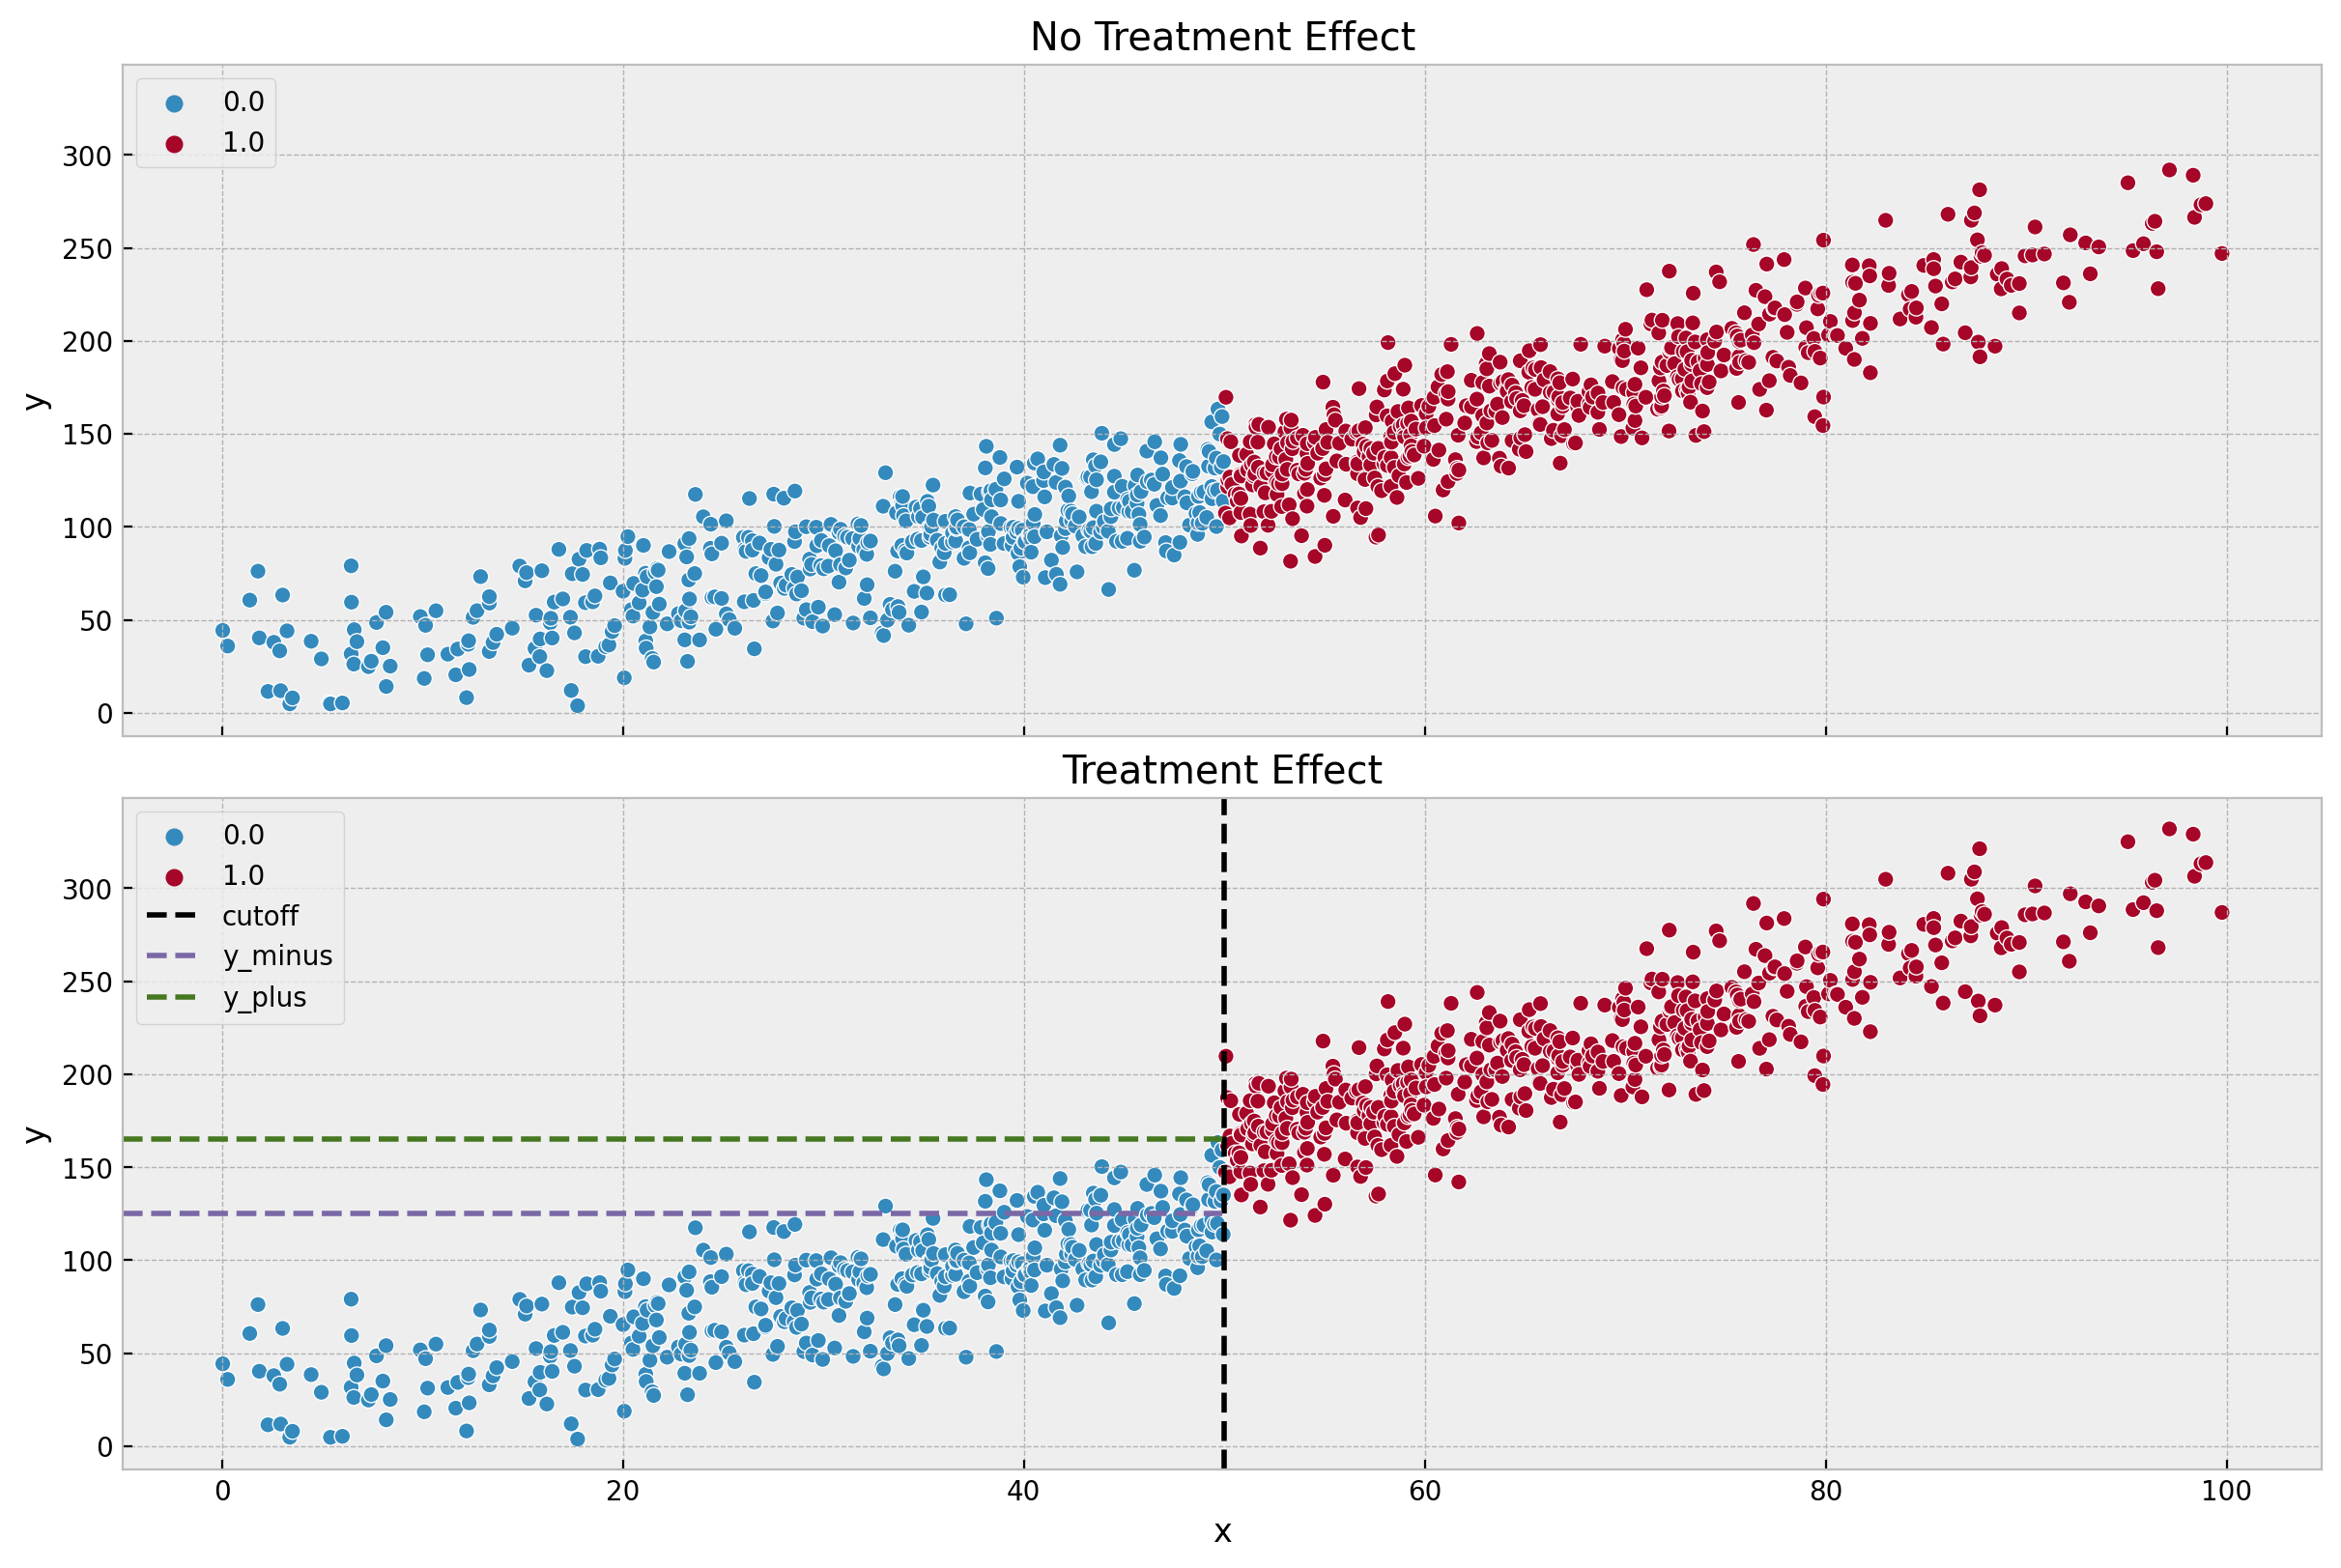

In [3]:
n = 1_000
c = 50
delta = 40

x = rng.normal(loc=c, scale=25, size=n)

d = (x > c).astype(float)

intercept = 25
slope = 1.5
quadratic = 0.01

y0 = (
    intercept
    + slope * x
    + quadratic * x**2
    + 0 * d
    + rng.normal(loc=0, scale=20, size=n)
)
y = y0 + delta * d

data = pd.DataFrame(data={"x": x, "d": d, "y0": y0, "y": y})
mask = "0 < x < 100 and 0 < y0 and 0 < y"
data = data.query(expr=mask).sort_values(by="x").reset_index(drop=True)

y_minus = intercept + slope * c + quadratic * c**2
y_plus = y_minus + delta

fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(12, 8), layout="constrained"
)
sns.scatterplot(data=data, x="x", y="y0", hue="d", ax=ax[0])
ax[0].legend(loc="upper left")
ax[0].set(title="No Treatment Effect", xlabel="x", ylabel="y")
sns.scatterplot(data=data, x="x", y="y", hue="d", ax=ax[1])
ax[1].axvline(x=c, color="black", linestyle="--", label="cutoff")
ax[1].axhline(
    y=y_minus,
    xmax=0.5,
    color="C2",
    linestyle="--",
    label="y_minus",
)
ax[1].axhline(
    y=y_plus,
    xmax=0.5,
    color="C3",
    linestyle="--",
    label="y_plus",
)
ax[1].legend(loc="upper left")
ax[1].set(title="Treatment Effect", xlabel="x", ylabel="y")


In [4]:
delta_true = y_plus - y_minus
delta_true

40.0

In [5]:
data["x_c"] = data["x"] - c


[Text(0.5, 1.0, 'Centered Synthetic Data'),
 Text(0.5, 0, 'x'),
 Text(0, 0.5, 'y')]

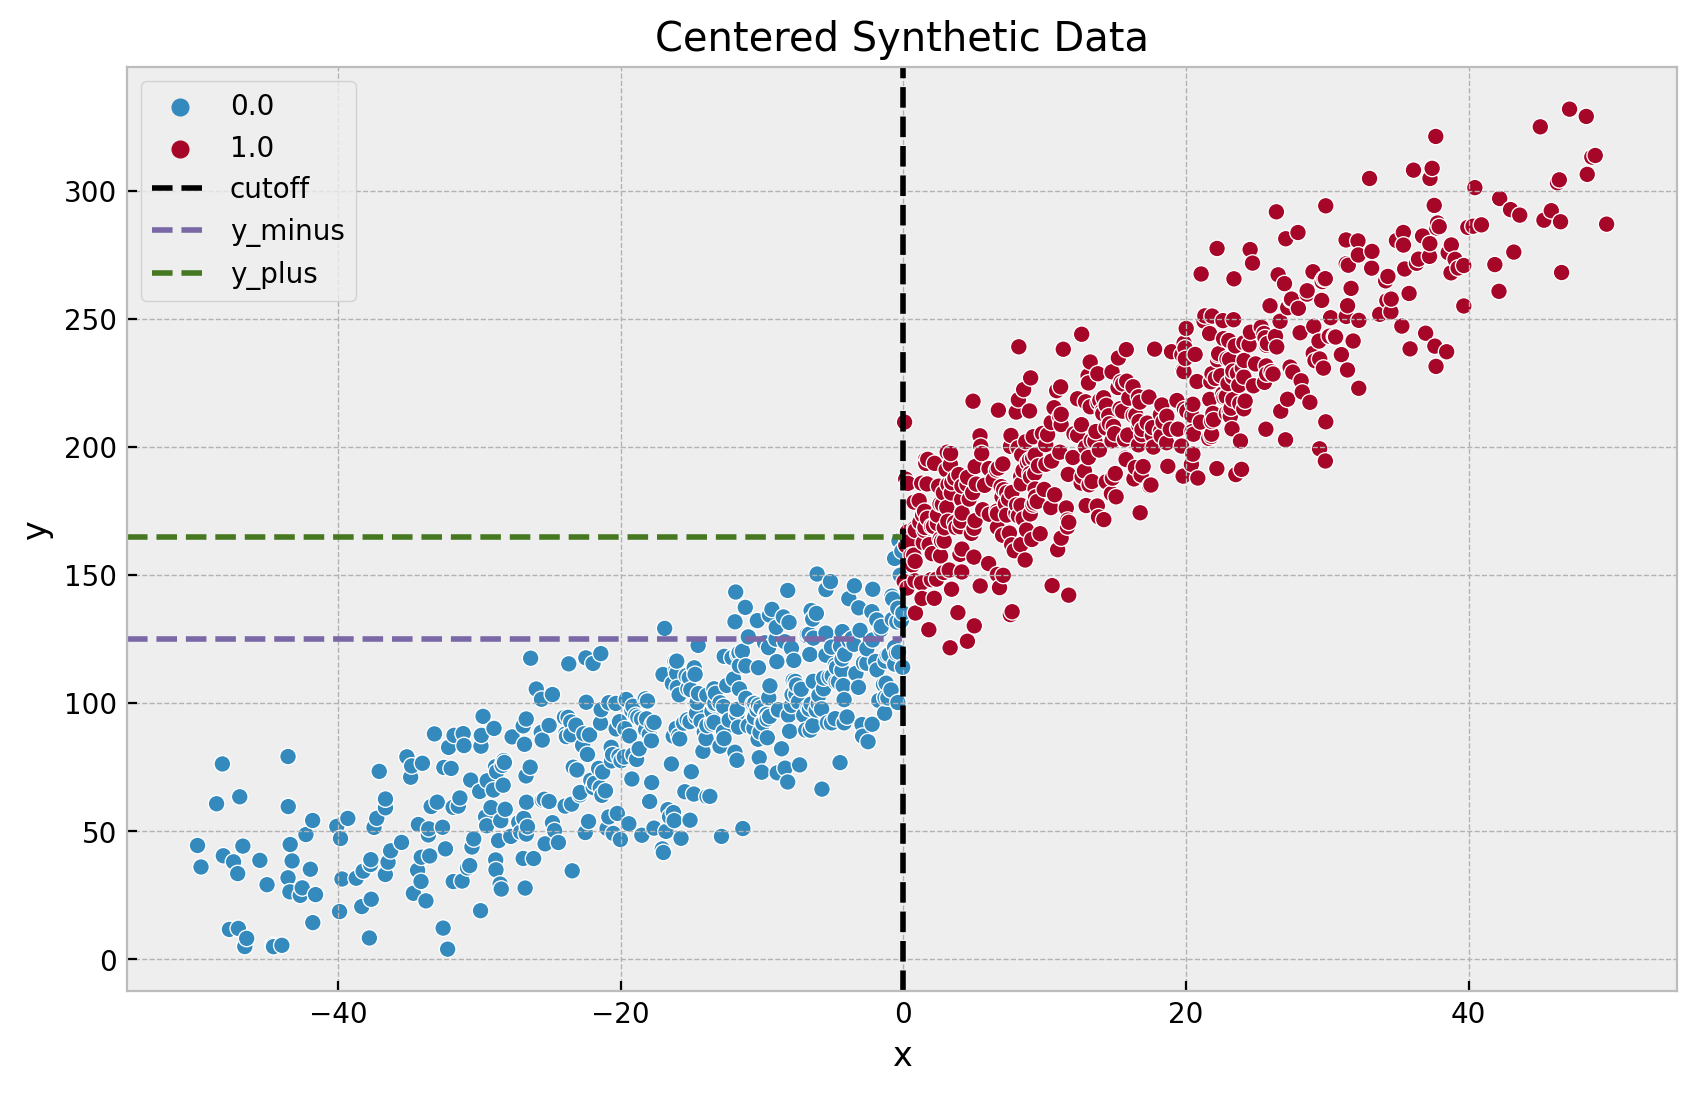

In [6]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", hue="d", ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
ax.axhline(
    y=y_minus,
    xmax=0.5,
    color="C2",
    linestyle="--",
    label="y_minus",
)
ax.axhline(
    y=y_plus,
    xmax=0.5,
    color="C3",
    linestyle="--",
    label="y_plus",
)
ax.legend(loc="upper left")
ax.set(title="Centered Synthetic Data", xlabel="x", ylabel="y")


In [7]:
data["x_c"] = data["x"] - c

obs_idx = data.index.to_numpy()
x_c = data["x_c"].to_numpy()
d = data["d"].to_numpy()
y = data["y"].to_numpy()

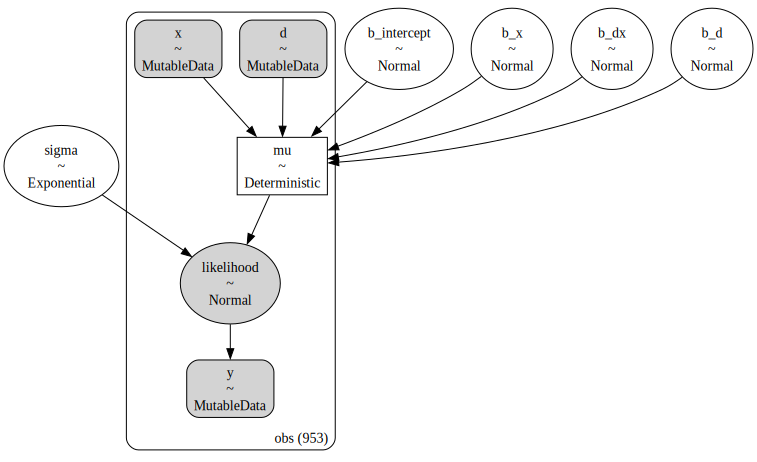

In [8]:
with pm.Model(coords={"obs": obs_idx}) as gaussian_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=100, sigma=60)
    b_x = pm.Normal(name="b_x", mu=0, sigma=5)
    b_d = pm.Normal(name="b_d", mu=50, sigma=20)
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=5)
    sigma = pm.Exponential(name="sigma", lam=1 / 50)
    # --- Deterministic Variables ---
    mu = pm.Deterministic(
        name="mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    # --- Likelihood ---
    pm.Normal(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gaussian_model)

In [9]:
with gaussian_model:
    gaussian_prior_predictive = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )

Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Linear Regression Model - Prior Predictive Distribution')]

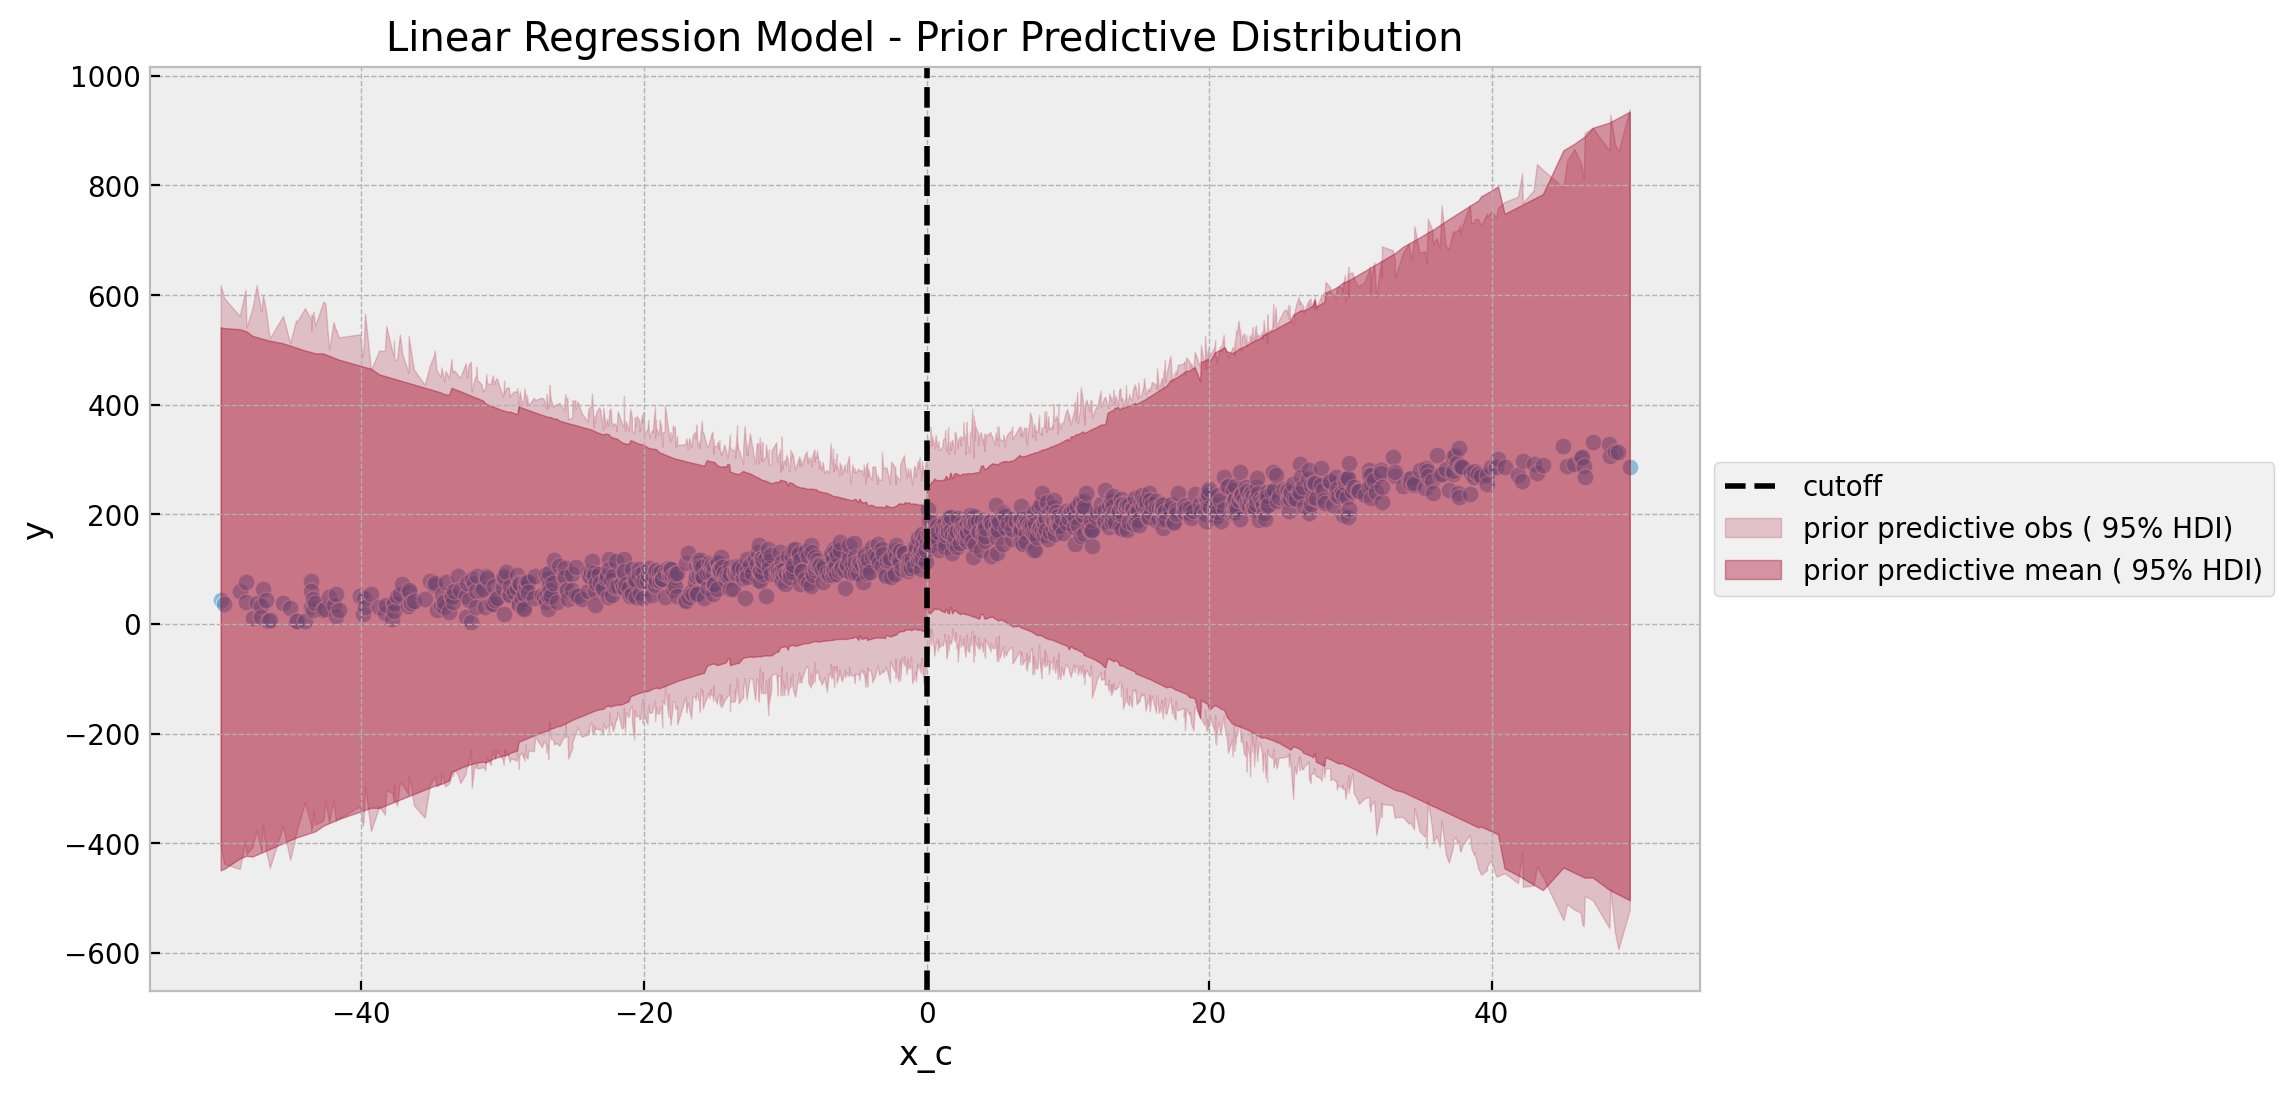

In [10]:
alpha = 0.05

fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gaussian_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gaussian_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Linear Regression Model - Prior Predictive Distribution")


In [11]:
with gaussian_model:
    gaussian_idata = pm.sample(
        draws=6_000, chains=4, nuts_sampler="numpyro", random_seed=rng
    )
    gaussian_posterior_predictive = pm.sample_posterior_predictive(
        trace=gaussian_idata, random_seed=rng
    )


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.764196
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:04.824510
Transforming variables...


In [12]:
gaussian_idata["sample_stats"]["diverging"].sum().item()

0

In [13]:
az.summary(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
)


/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


mean     sd   hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept  122.653  1.653  119.554  125.756      0.018    0.013    8276.0   
b_x            2.052  0.074    1.911    2.189      0.001    0.001    8612.0   
b_d           37.993  2.287   33.685   42.306      0.022    0.016   10554.0   
b_dx           0.925  0.104    0.729    1.119      0.001    0.001   11192.0   
sigma         19.723  0.455   18.846   20.558      0.004    0.003   15516.0   

             ess_tail  r_hat  
b_intercept   11641.0    1.0  
b_x           11962.0    1.0  
b_d           12988.0    1.0  
b_dx          13133.0    1.0  
sigma         14580.0    1.0

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Text(0.5, 0.98, 'Linear Regression Model - Trace')

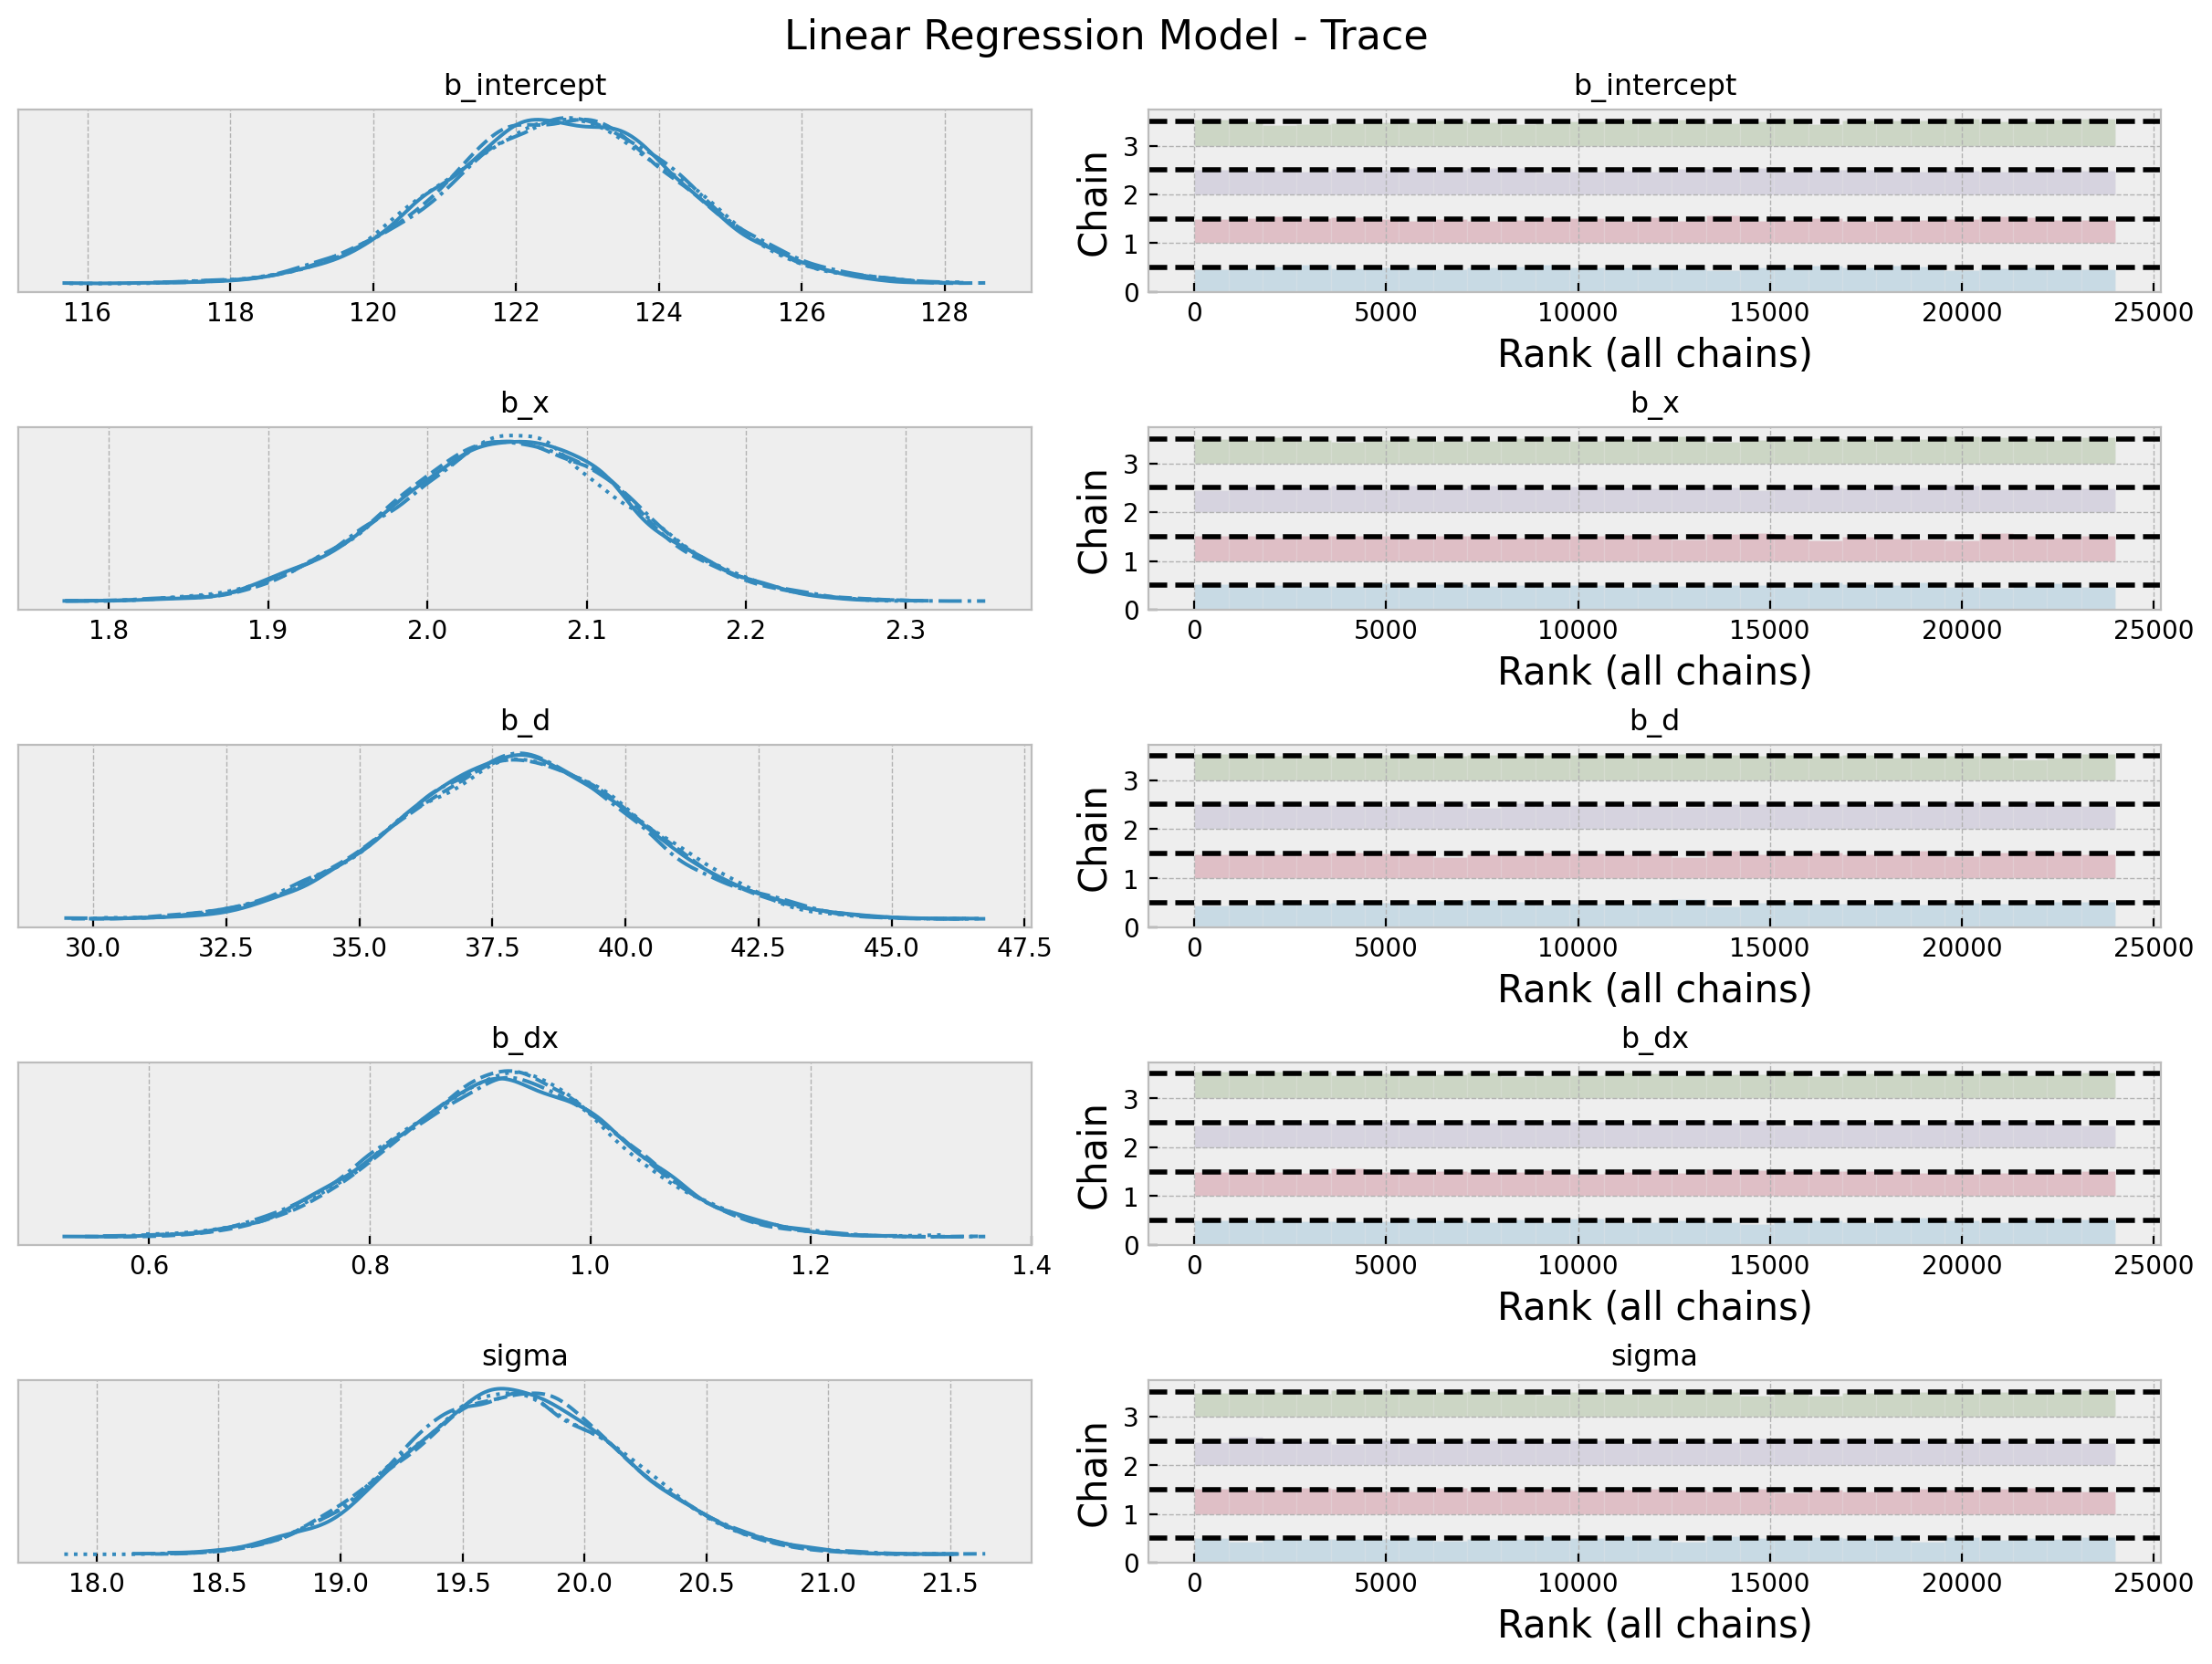

In [14]:
axes = az.plot_trace(
    data=gaussian_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16)

[Text(0.5, 1.0, 'Linear Regression Model')]

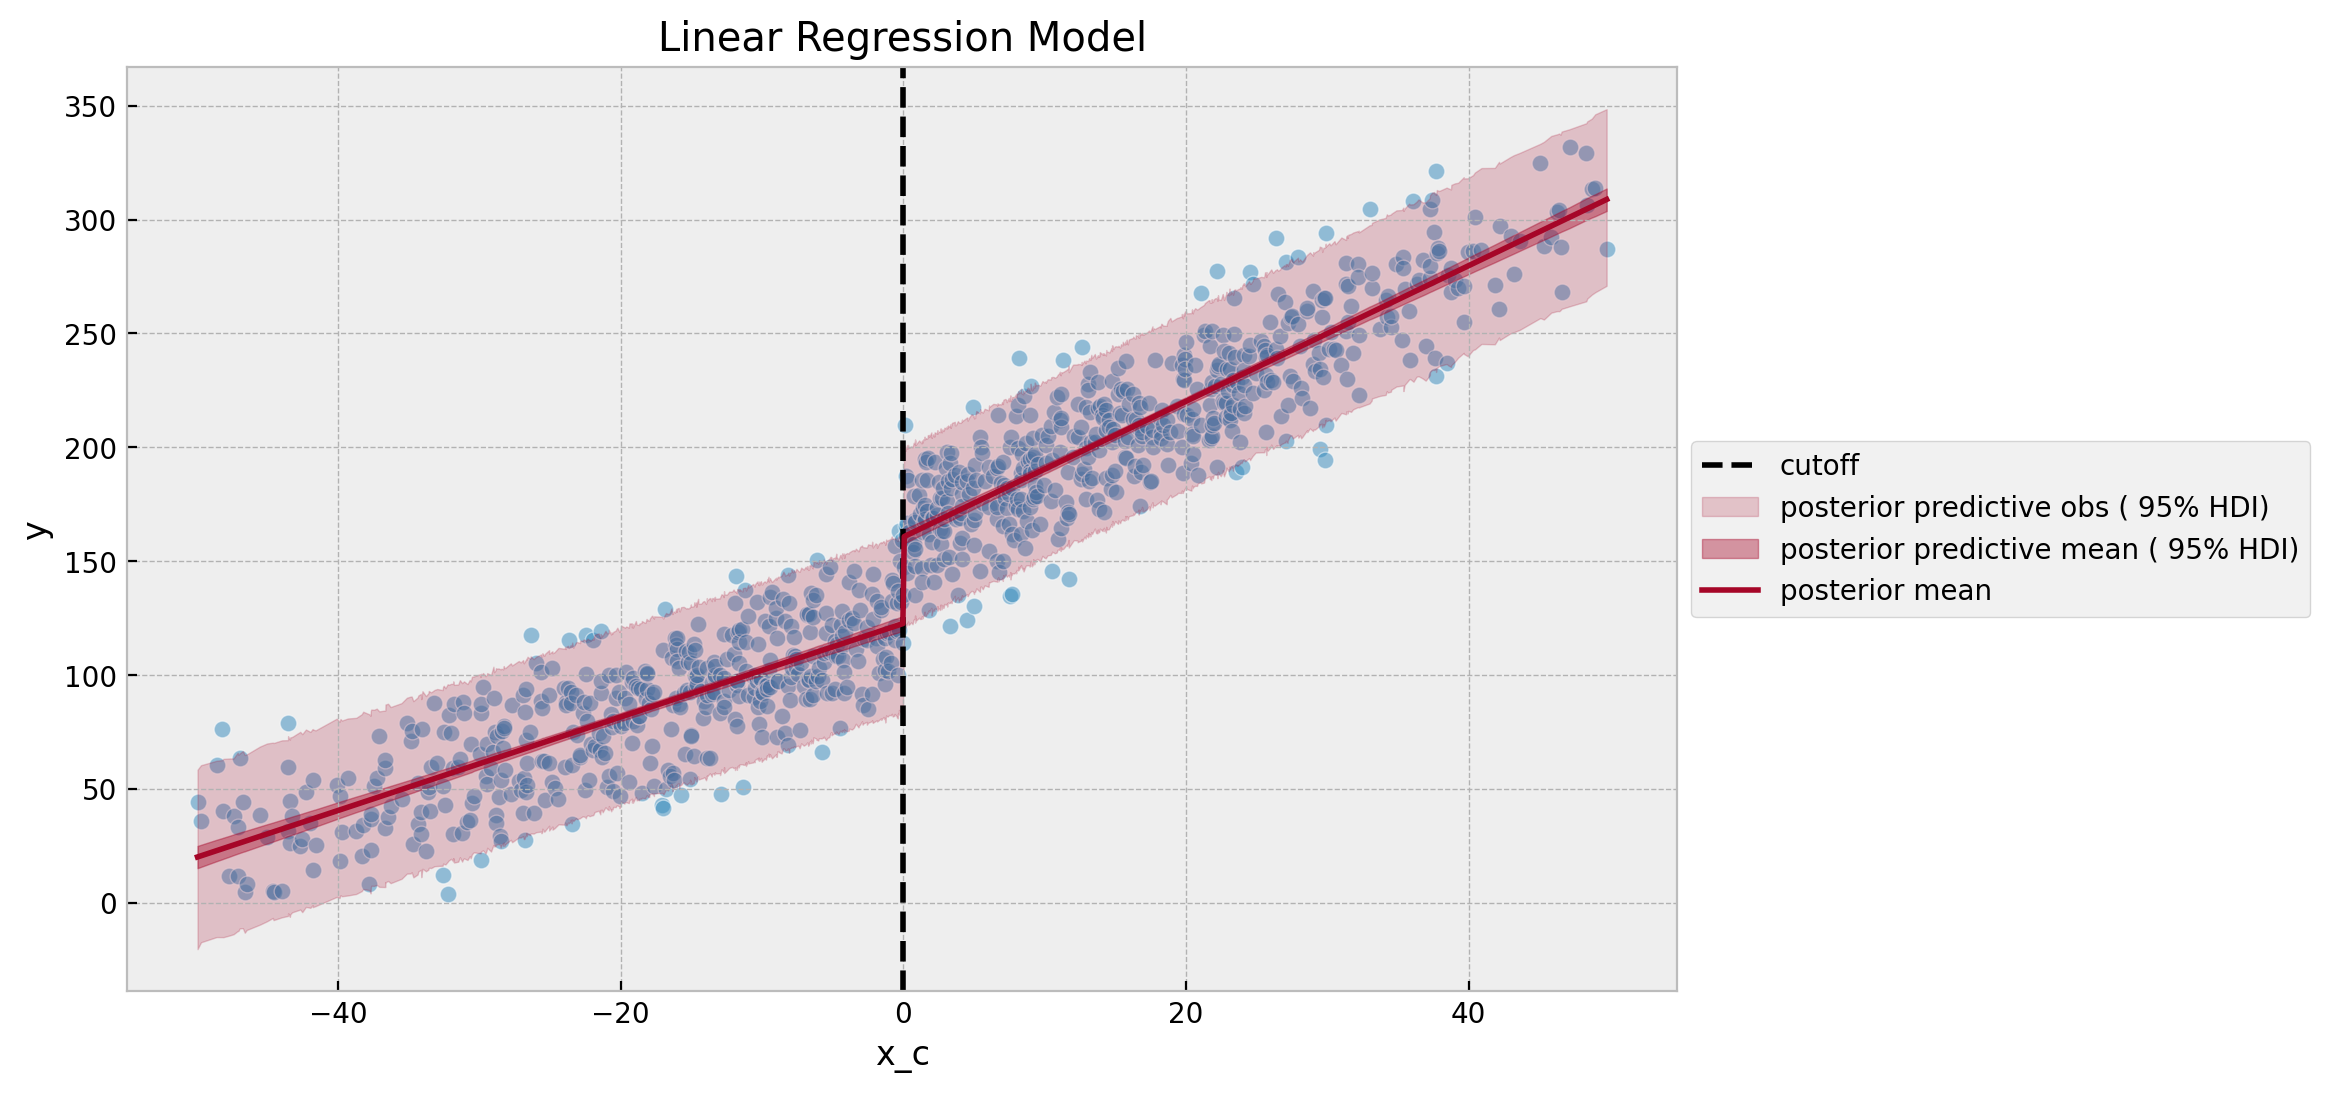

In [15]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gaussian_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gaussian_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gaussian_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Linear Regression Model")


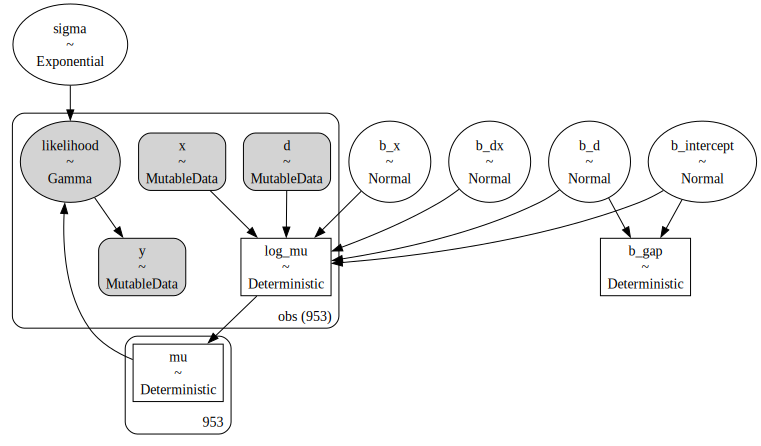

In [16]:
with pm.Model(coords={"obs": obs_idx}) as gamma_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=np.log(150), sigma=np.log(2))
    b_x = pm.Normal(name="b_x", mu=0, sigma=np.log(1 + 0.05))
    b_d = pm.Normal(name="b_d", mu=0.05, sigma=np.log(3))
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=np.log(1 + 0.01))
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    log_mu = pm.Deterministic(
        name="log_mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    mu = pm.Deterministic(name="mu", var=pm.math.exp(log_mu))
    pm.Deterministic(
        name="b_gap", var=pm.math.exp(b_intercept) * (pm.math.exp(b_d) - 1)
    )
    # --- Likelihood ---
    pm.Gamma(
        name="likelihood",
        mu=mu,
        sigma=sigma,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=gamma_model)

In [17]:
with gamma_model:
    gamma_prior_predictive = pm.sample_prior_predictive(samples=1_000, random_seed=rng)

Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Gamma Regression Model - Prior Predictive Distribution')]

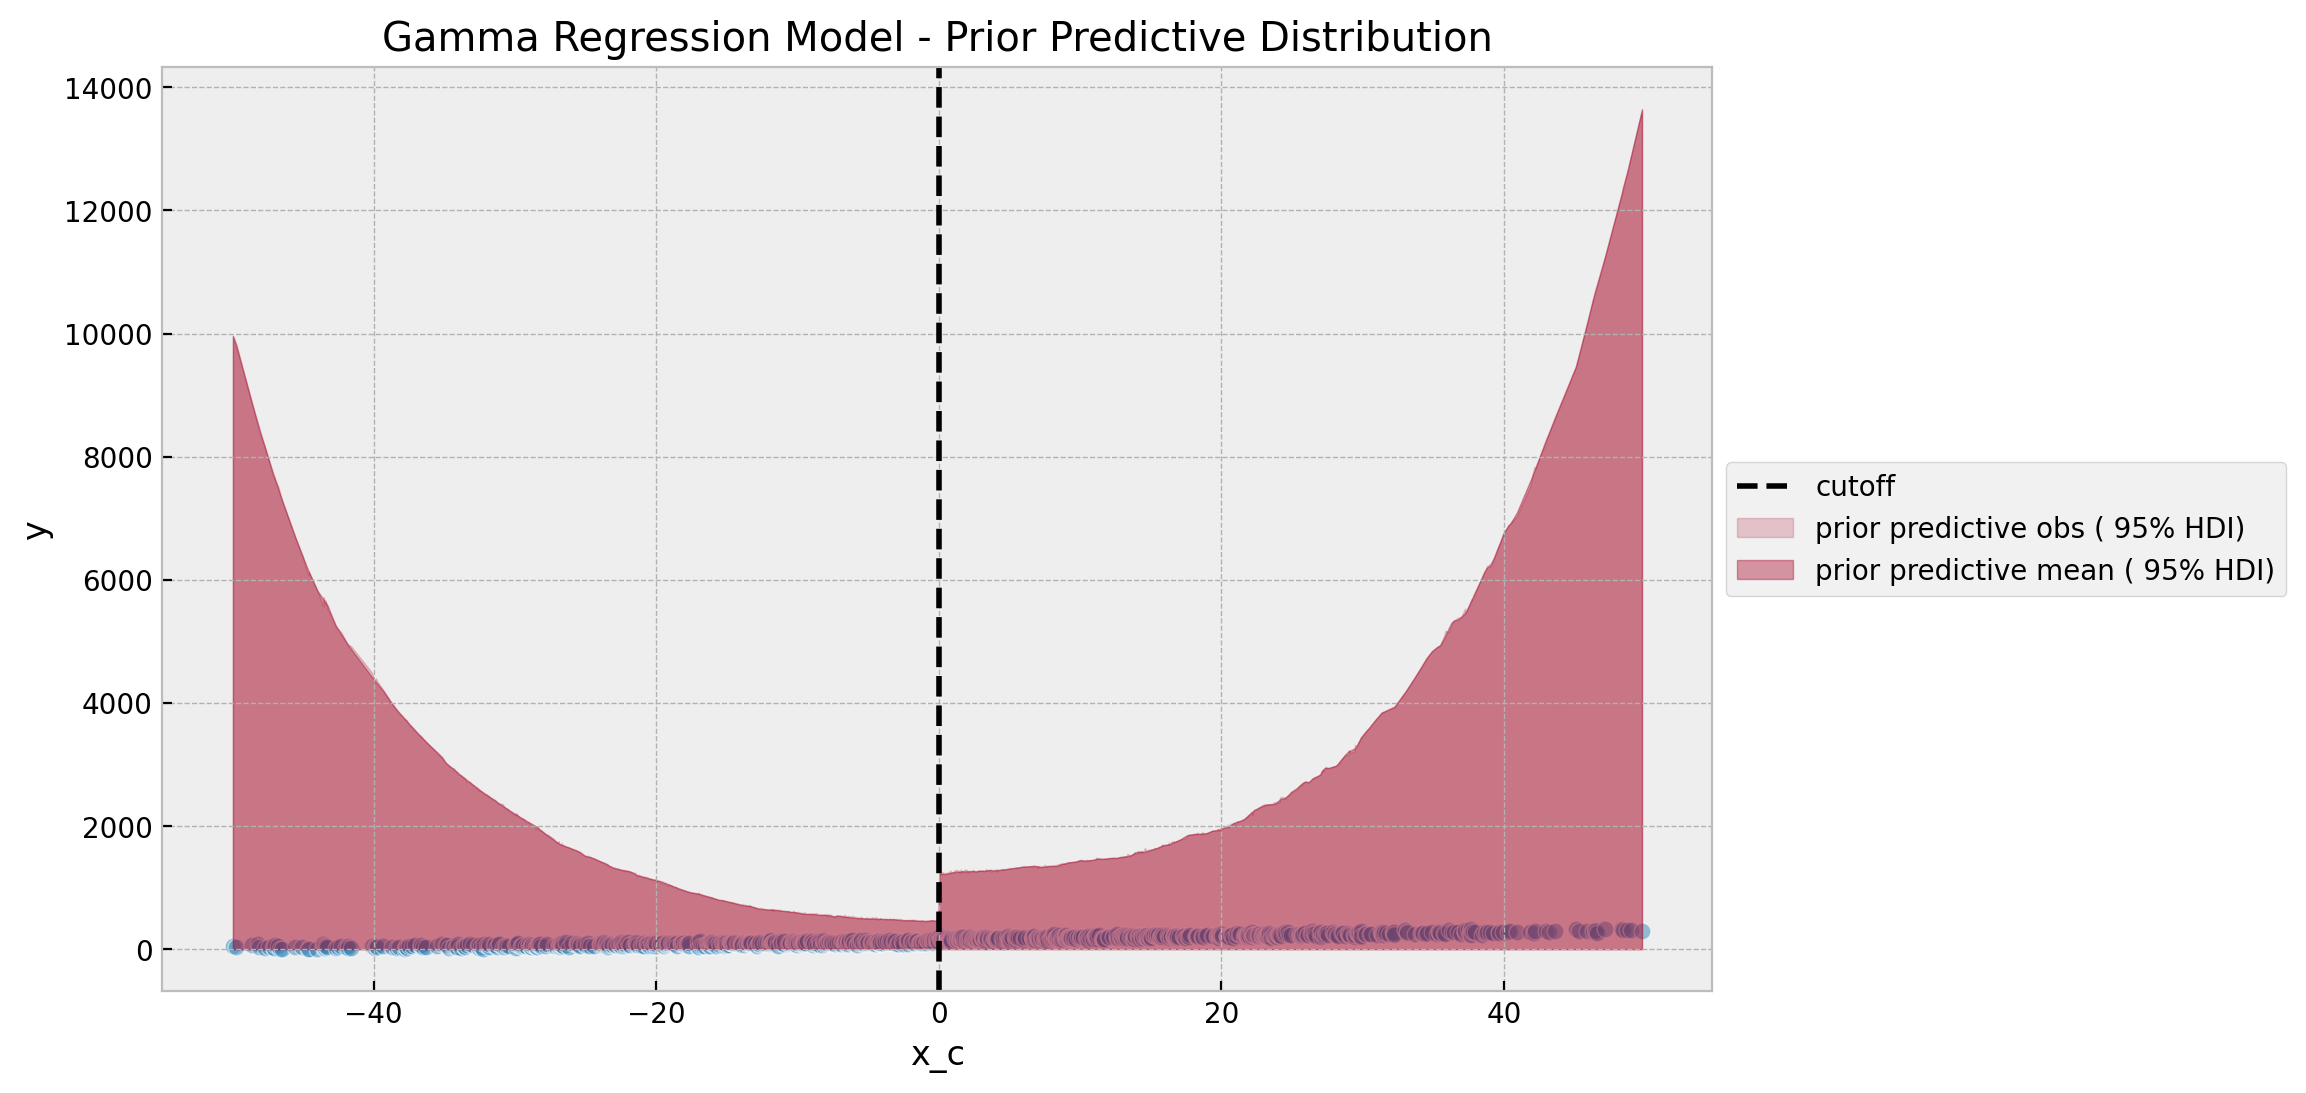

In [18]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gamma_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gamma_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model - Prior Predictive Distribution")


[Text(0.5, 1.0, 'Gamma Regression Model - Prior Predictive Distribution')]

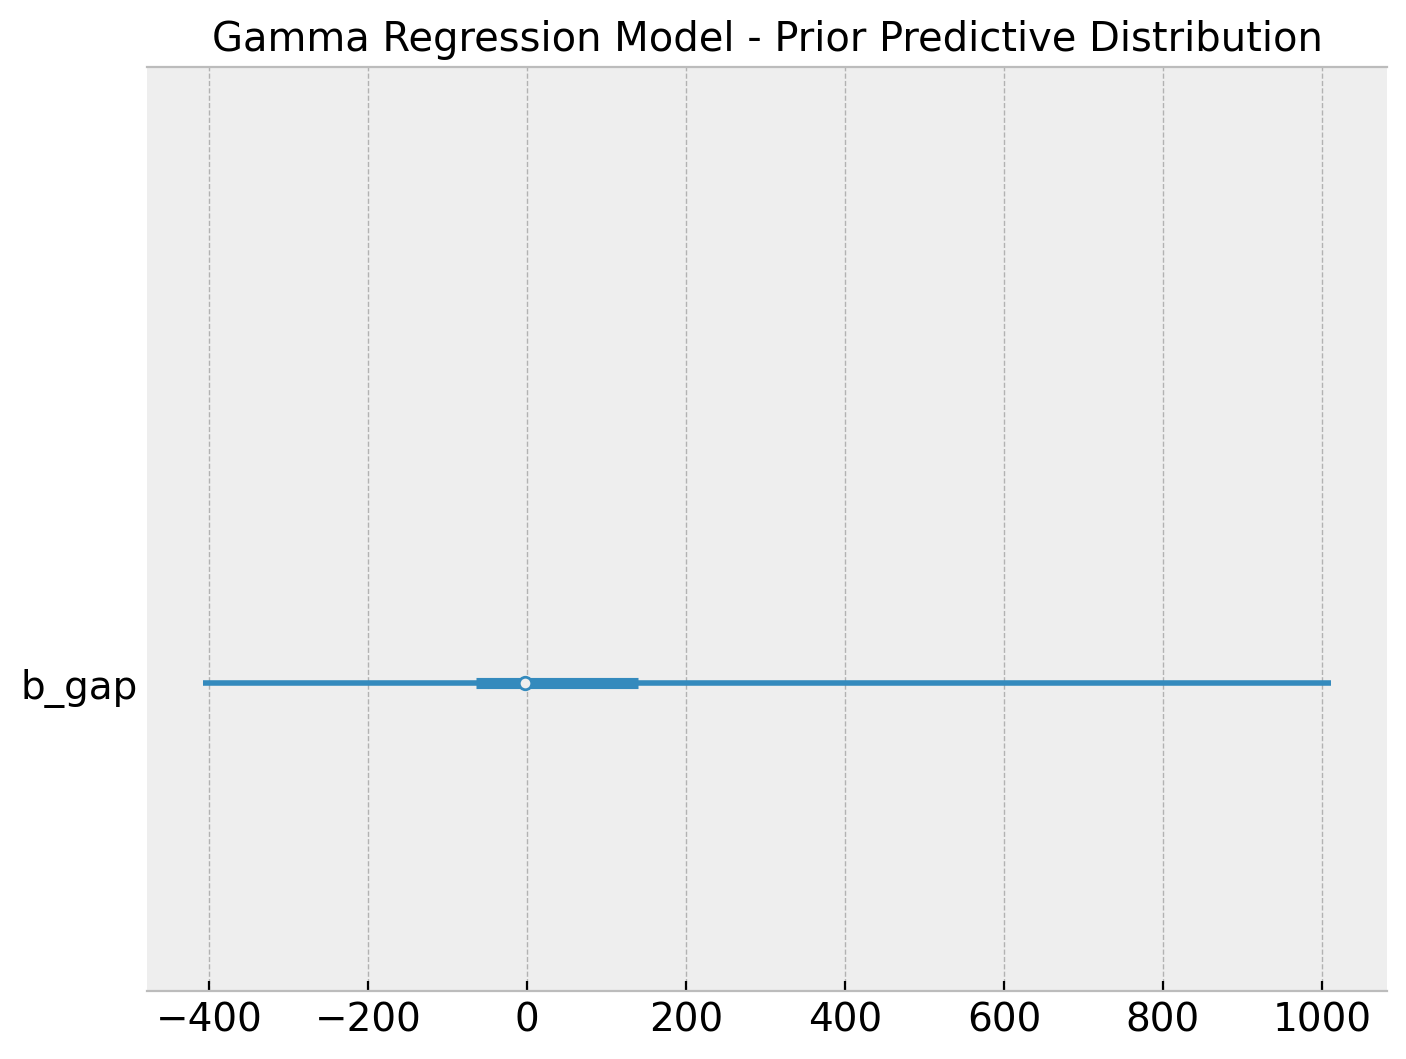

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
az.plot_forest(
    data=gamma_prior_predictive["prior"], var_names=["b_gap"], combined=True, ax=ax
)
ax.set(title="Gamma Regression Model - Prior Predictive Distribution")

In [20]:
with gamma_model:
    gamma_idata = pm.sample(
        draws=6_000, chains=4, nuts_sampler="numpyro", random_seed=rng
    )
    gamma_posterior_predictive = pm.sample_posterior_predictive(
        trace=gamma_idata, random_seed=rng
    )

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.216396
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:54.618668
Transforming variables...


In [21]:
gamma_idata["sample_stats"]["diverging"].sum().item()

0

In [22]:
az.summary(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept   4.886  0.016   4.857    4.915      0.000    0.000    6457.0   
b_x           0.028  0.001   0.026    0.029      0.000    0.000    9044.0   
b_d           0.229  0.018   0.195    0.262      0.000    0.000    6542.0   
b_dx         -0.014  0.001  -0.016   -0.013      0.000    0.000   10363.0   
sigma        20.672  0.483  19.767   21.583      0.005    0.004    8086.0   
b_gap        34.079  2.487  29.237   38.670      0.030    0.021    6826.0   

             ess_tail  r_hat  
b_intercept    7699.0    1.0  
b_x           12495.0    1.0  
b_d            8073.0    1.0  
b_dx          14221.0    1.0  
sigma          8981.0    1.0  
b_gap          8586.0    1.0

Text(0.5, 0.98, 'Gamma Regression Model - Trace')

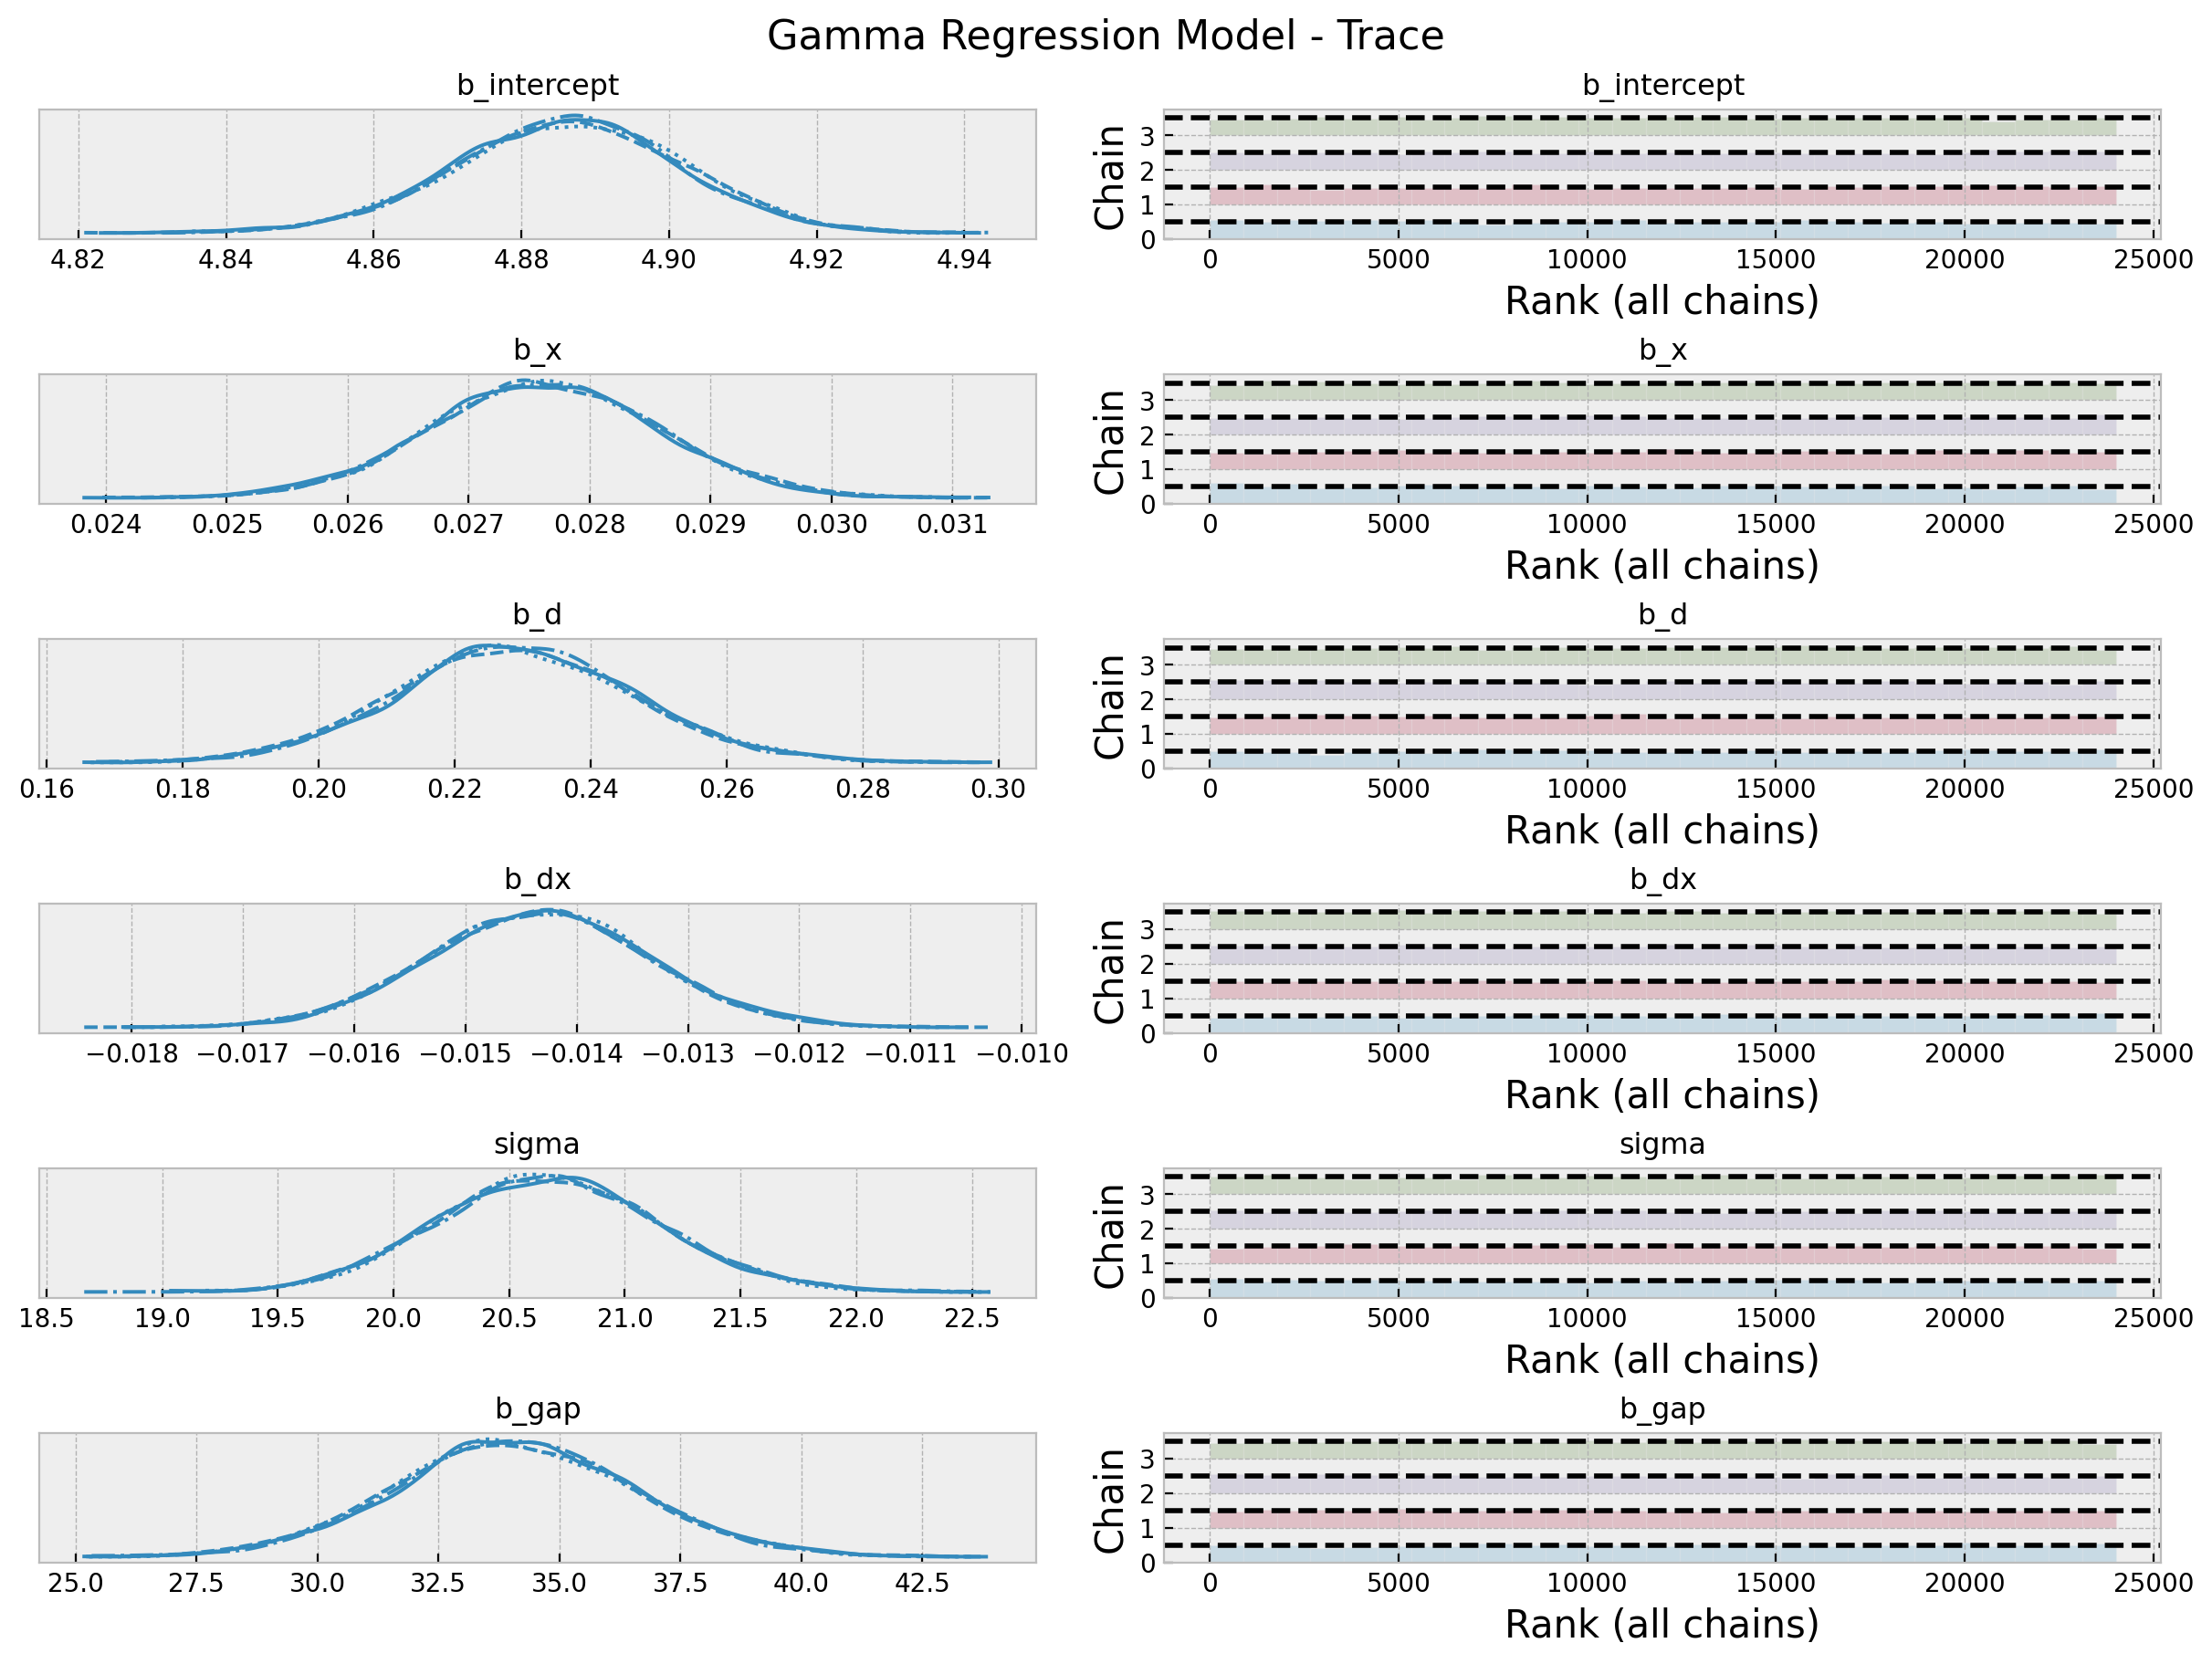

In [23]:
axes = az.plot_trace(
    data=gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Gamma Regression Model - Trace", fontsize=16)

[Text(0.5, 1.0, 'Gamma Regression Model')]

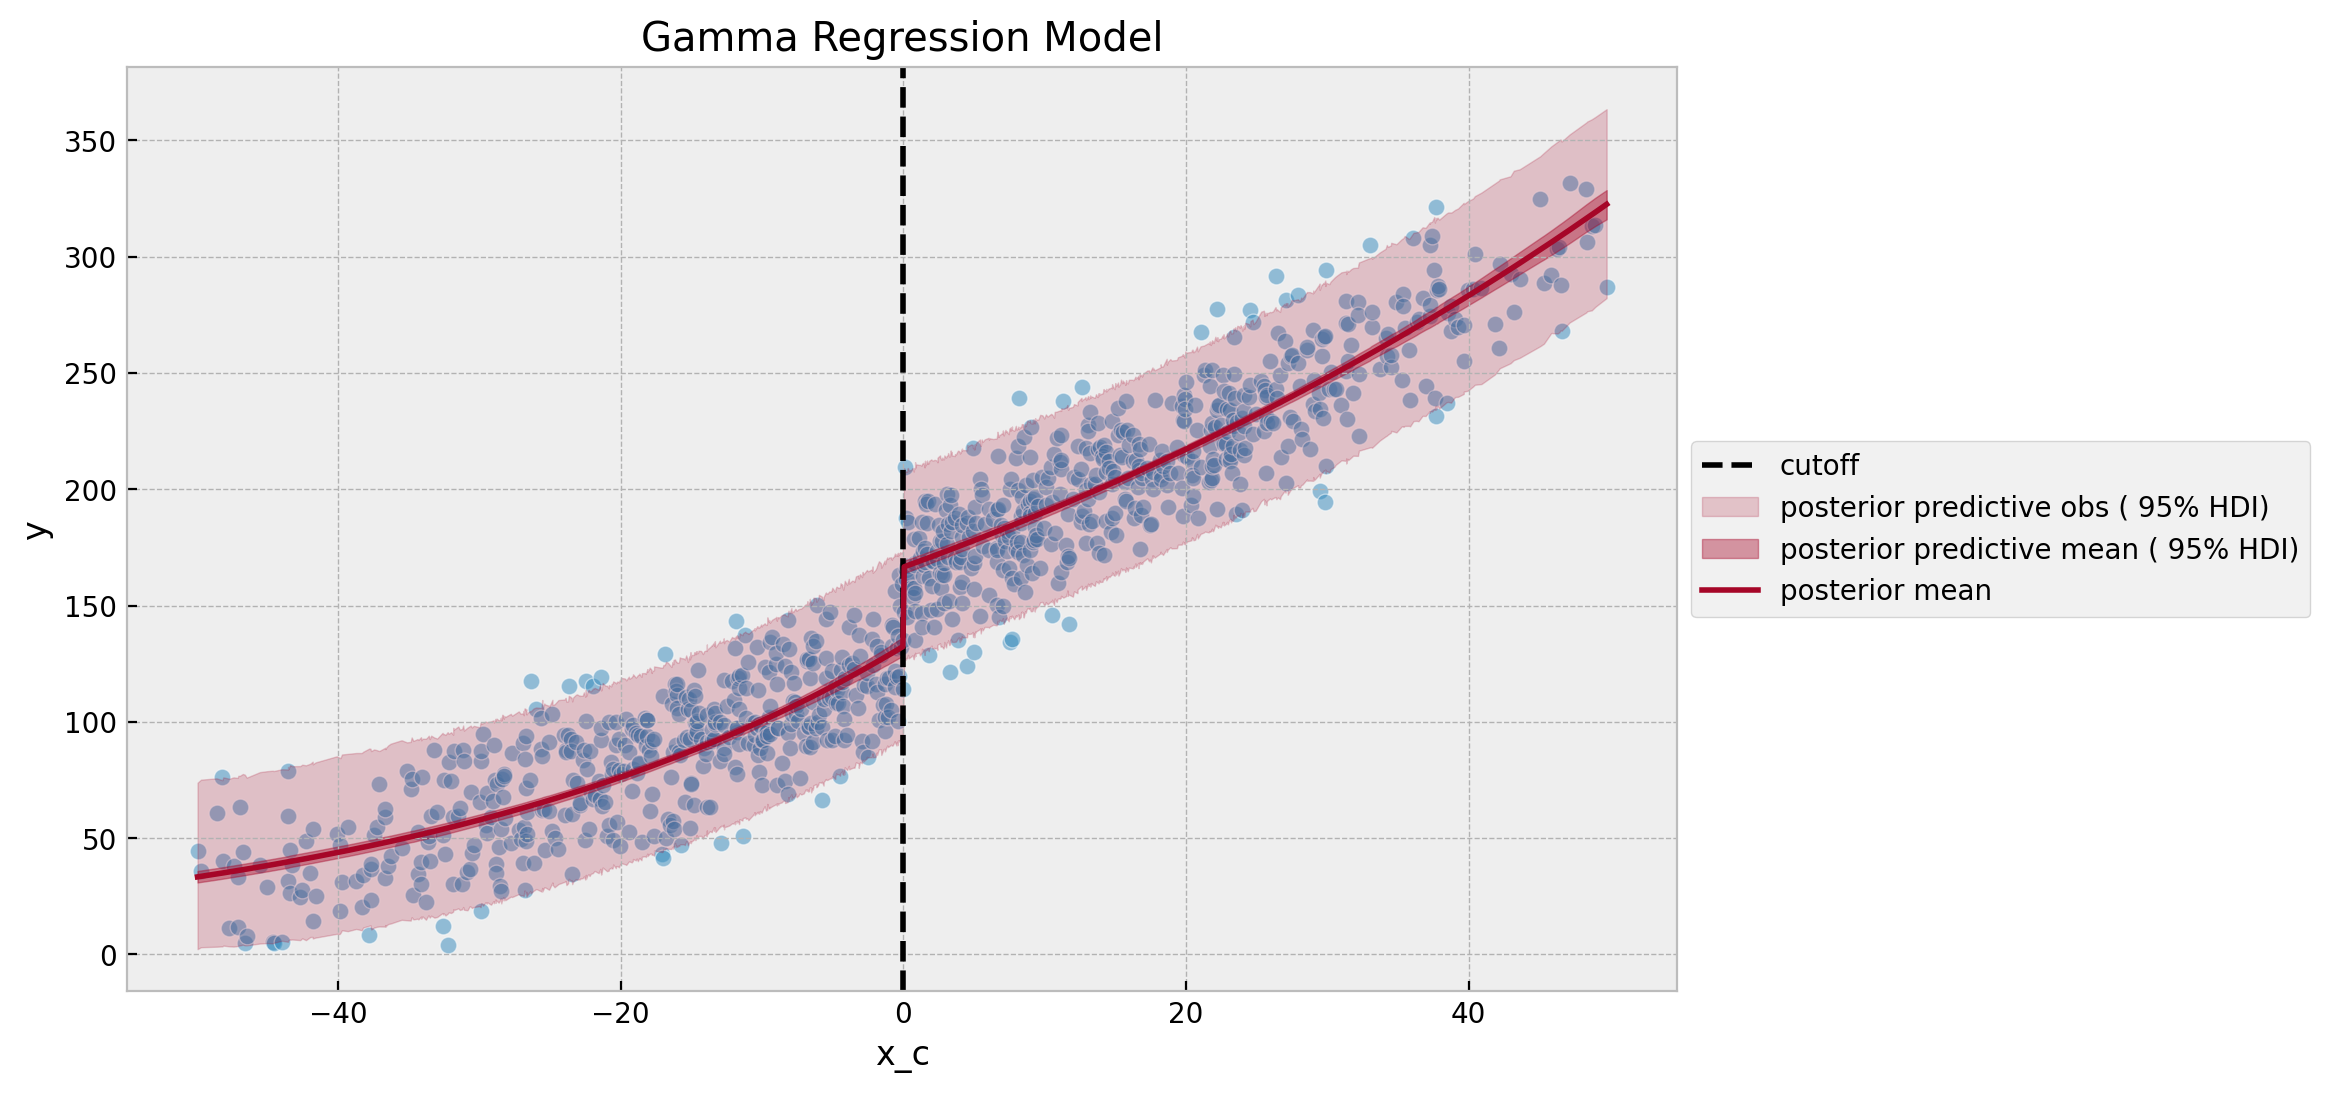

In [24]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    gamma_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    gamma_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=gamma_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model")


[Text(0.5, 1.0, 'Kernel Function'),
 Text(0.5, 0, 'time centered'),
 Text(0, 0.5, 'kernel value')]

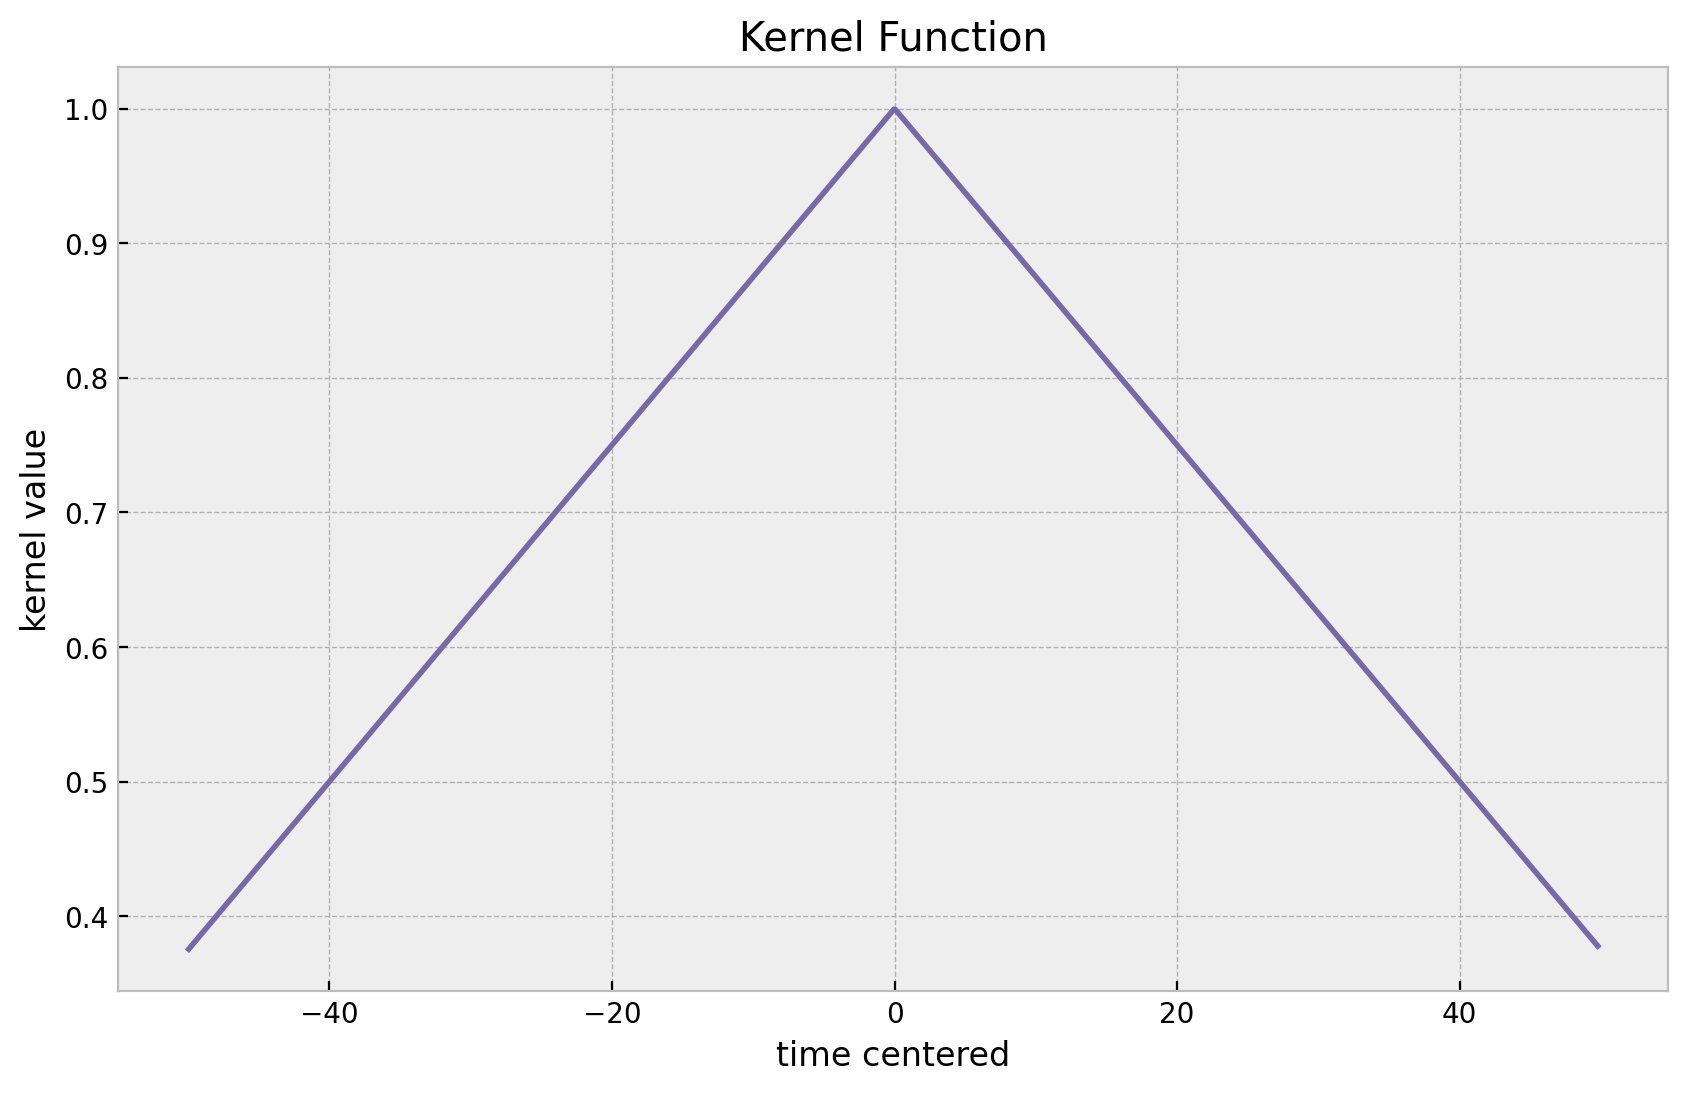

In [25]:
def kernel(r, c, h):
    indicator = (np.abs(r - c) <= h).astype(float)
    return indicator * (1 - np.abs(r - c) / h)


data["kernel"] = kernel(r=data["x_c"], c=0, h=80)
kernel = data["kernel"].to_numpy()

fig, ax = plt.subplots()
sns.lineplot(data=data, x="x_c", y="kernel", color="C2", ax=ax)
ax.set(title="Kernel Function", xlabel="time centered", ylabel="kernel value")

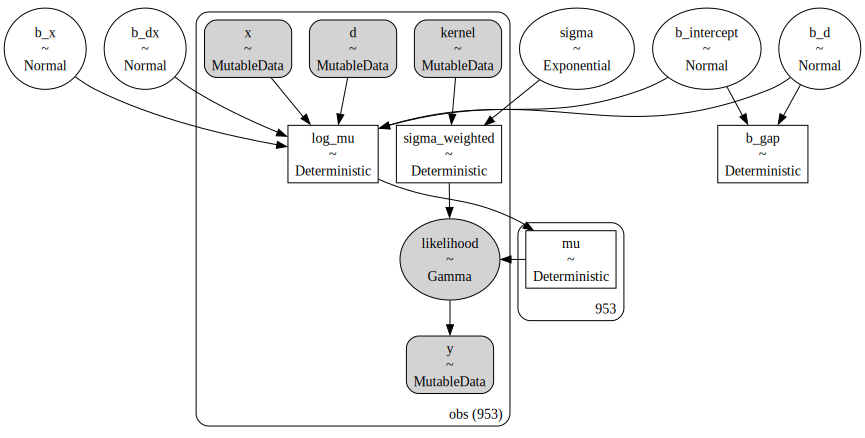

In [26]:
with pm.Model(coords={"obs": obs_idx}) as weighted_gamma_model:
    # --- Data Containers ---
    x_ = pm.MutableData(name="x", value=x_c, dims="obs")
    d_ = pm.MutableData(name="d", value=d, dims="obs")
    y_ = pm.MutableData(name="y", value=y, dims="obs")
    kernel_ = pm.MutableData(name="kernel", value=kernel, dims="obs")
    # --- Priors ---
    b_intercept = pm.Normal(name="b_intercept", mu=np.log(150), sigma=np.log(2))
    b_x = pm.Normal(name="b_x", mu=0, sigma=np.log(1 + 0.05))
    b_d = pm.Normal(name="b_d", mu=0.05, sigma=np.log(3))
    b_dx = pm.Normal(name="b_dx", mu=0, sigma=np.log(1 + 0.01))
    sigma = pm.Exponential(name="sigma", lam=1 / 20)
    # --- Deterministic Variables ---
    log_mu = pm.Deterministic(
        name="log_mu",
        var=b_intercept + b_x * x_ + b_d * d_ + b_dx * d_ * x_,
        dims="obs",
    )
    mu = pm.Deterministic(name="mu", var=pm.math.exp(log_mu))
    pm.Deterministic(
        name="b_gap", var=pm.math.exp(b_intercept) * (pm.math.exp(b_d) - 1)
    )
    sigma_weighted = pm.Deterministic(
        name="sigma_weighted", var=sigma / kernel_, dims="obs"
    )
    # --- Likelihood ---
    pm.Gamma(
        name="likelihood",
        mu=mu,
        sigma=sigma_weighted,
        observed=y_,
        dims="obs",
    )

pm.model_to_graphviz(model=weighted_gamma_model)

In [27]:
with weighted_gamma_model:
    weighted_gamma_prior_predictive = pm.sample_prior_predictive(
        samples=1_000, random_seed=rng
    )

Sampling: [b_d, b_dx, b_intercept, b_x, likelihood, sigma]


[Text(0.5, 1.0, 'Weighted Gamma Regression Model - Prior Predictive Distribution')]

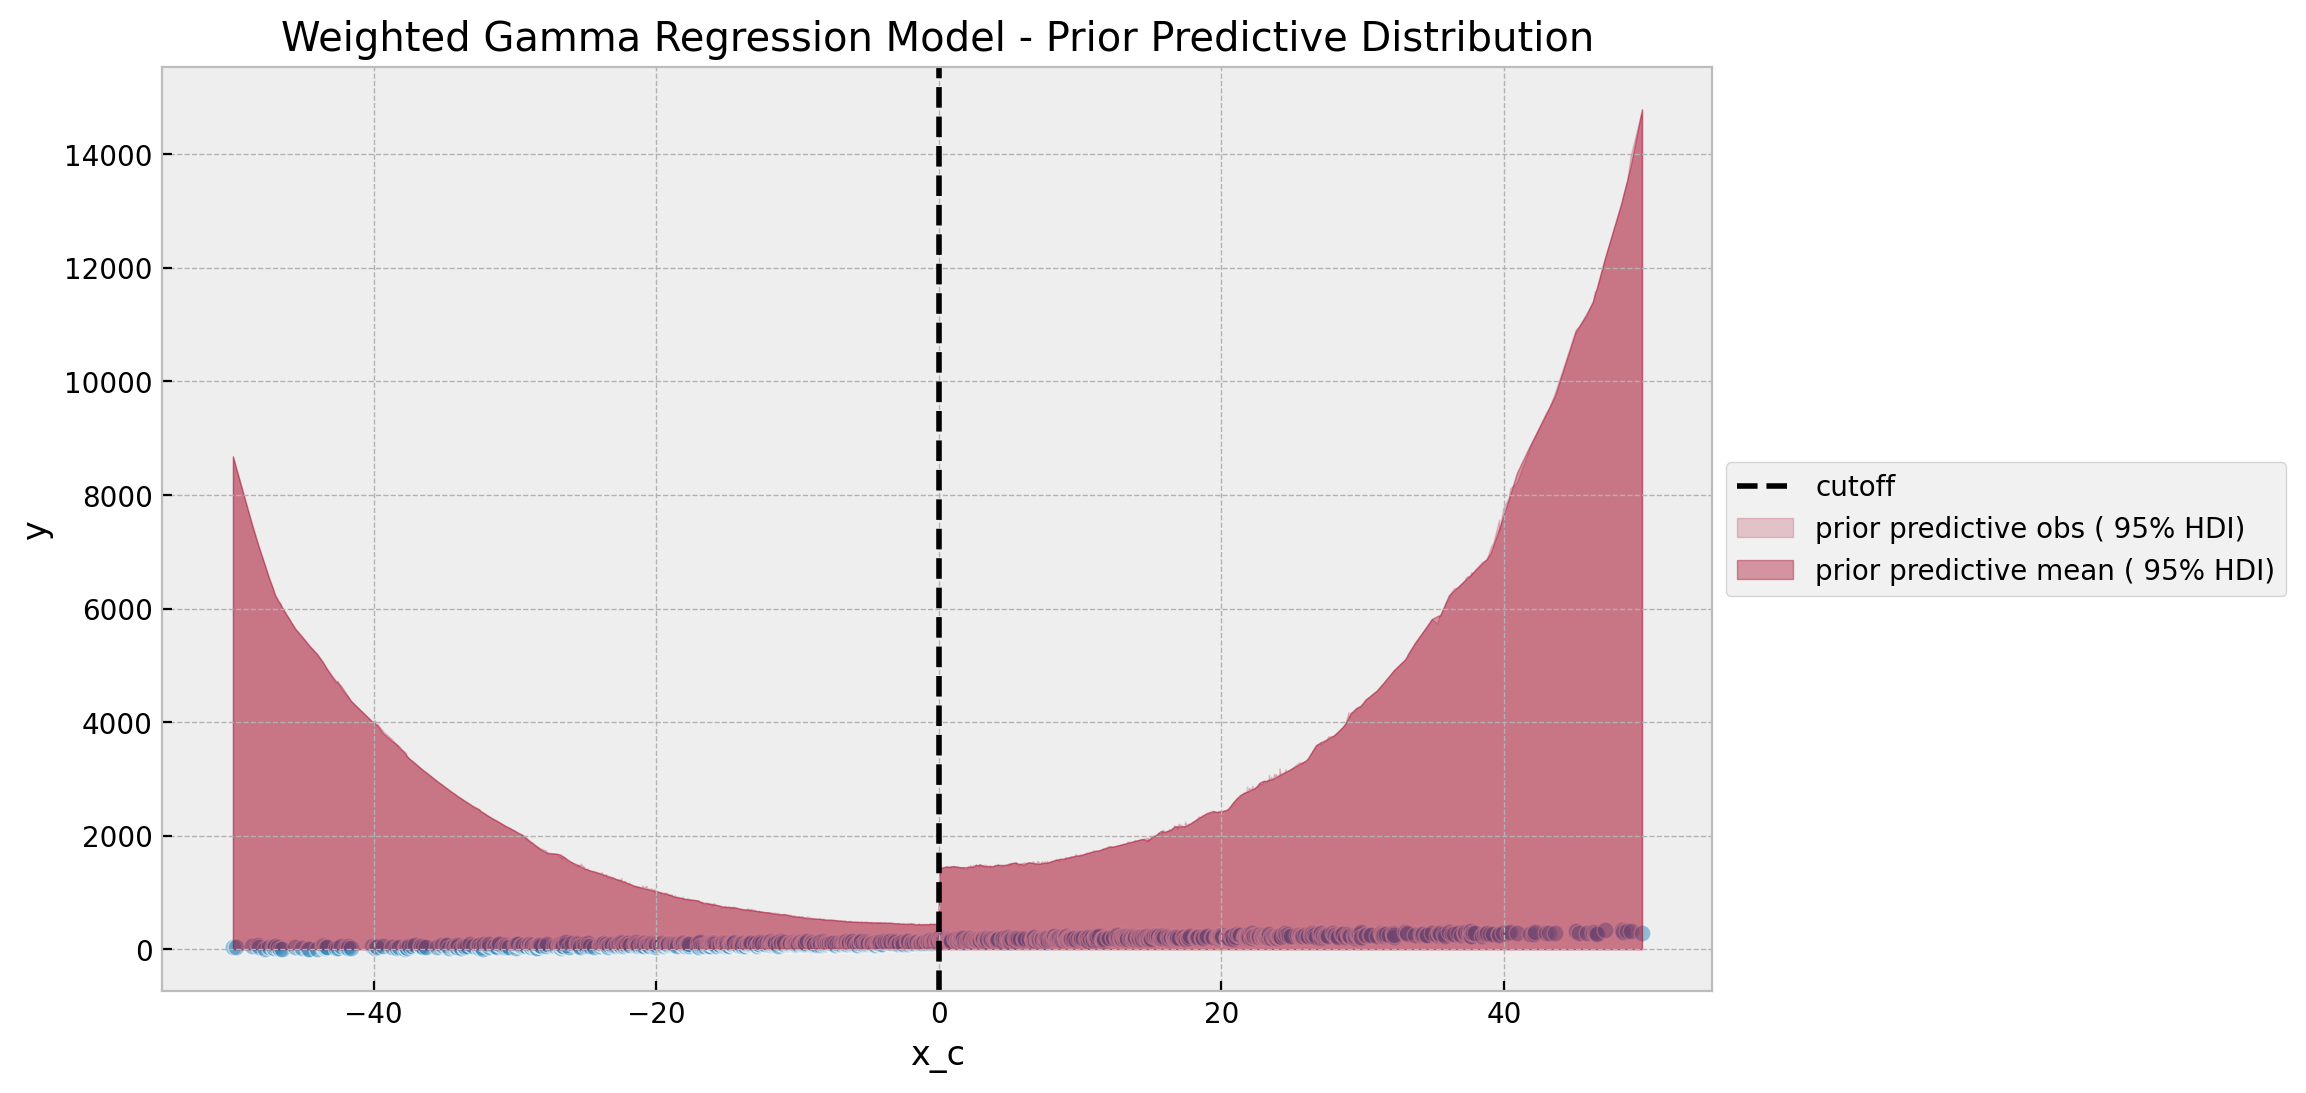

In [28]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    weighted_gamma_prior_predictive["prior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    weighted_gamma_prior_predictive["prior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"prior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Weighted Gamma Regression Model - Prior Predictive Distribution")


In [29]:
with weighted_gamma_model:
    weighted_gamma_idata = pm.sample(draws=6_000, chains=4, nuts_sampler="numpyro")
    weighted_gamma_posterior_predictive = pm.sample_posterior_predictive(
        trace=weighted_gamma_idata
    )

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:03.047439
Sampling...


  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

  0%|          | 0/7000 [00:00<?, ?it/s]

Sampling time =  0:00:44.635384
Transforming variables...


In [30]:
weighted_gamma_idata["sample_stats"]["diverging"].sum().item()

0

In [31]:
az.summary(
    data=weighted_gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
b_intercept   4.844  0.014   4.817    4.871      0.000    0.000    7065.0   
b_x           0.024  0.001   0.022    0.025      0.000    0.000    9803.0   
b_d           0.258  0.016   0.228    0.289      0.000    0.000    7159.0   
b_dx         -0.010  0.001  -0.012   -0.007      0.000    0.000   11615.0   
sigma        16.020  0.381  15.306   16.738      0.004    0.003    8315.0   
b_gap        37.359  2.197  33.227   41.509      0.025    0.018    7575.0   

             ess_tail  r_hat  
b_intercept    8484.0    1.0  
b_x           12052.0    1.0  
b_d            8281.0    1.0  
b_dx          14025.0    1.0  
sigma          9093.0    1.0  
b_gap          9849.0    1.0

Text(0.5, 0.98, 'Weighted Gamma Regression Model - Trace')

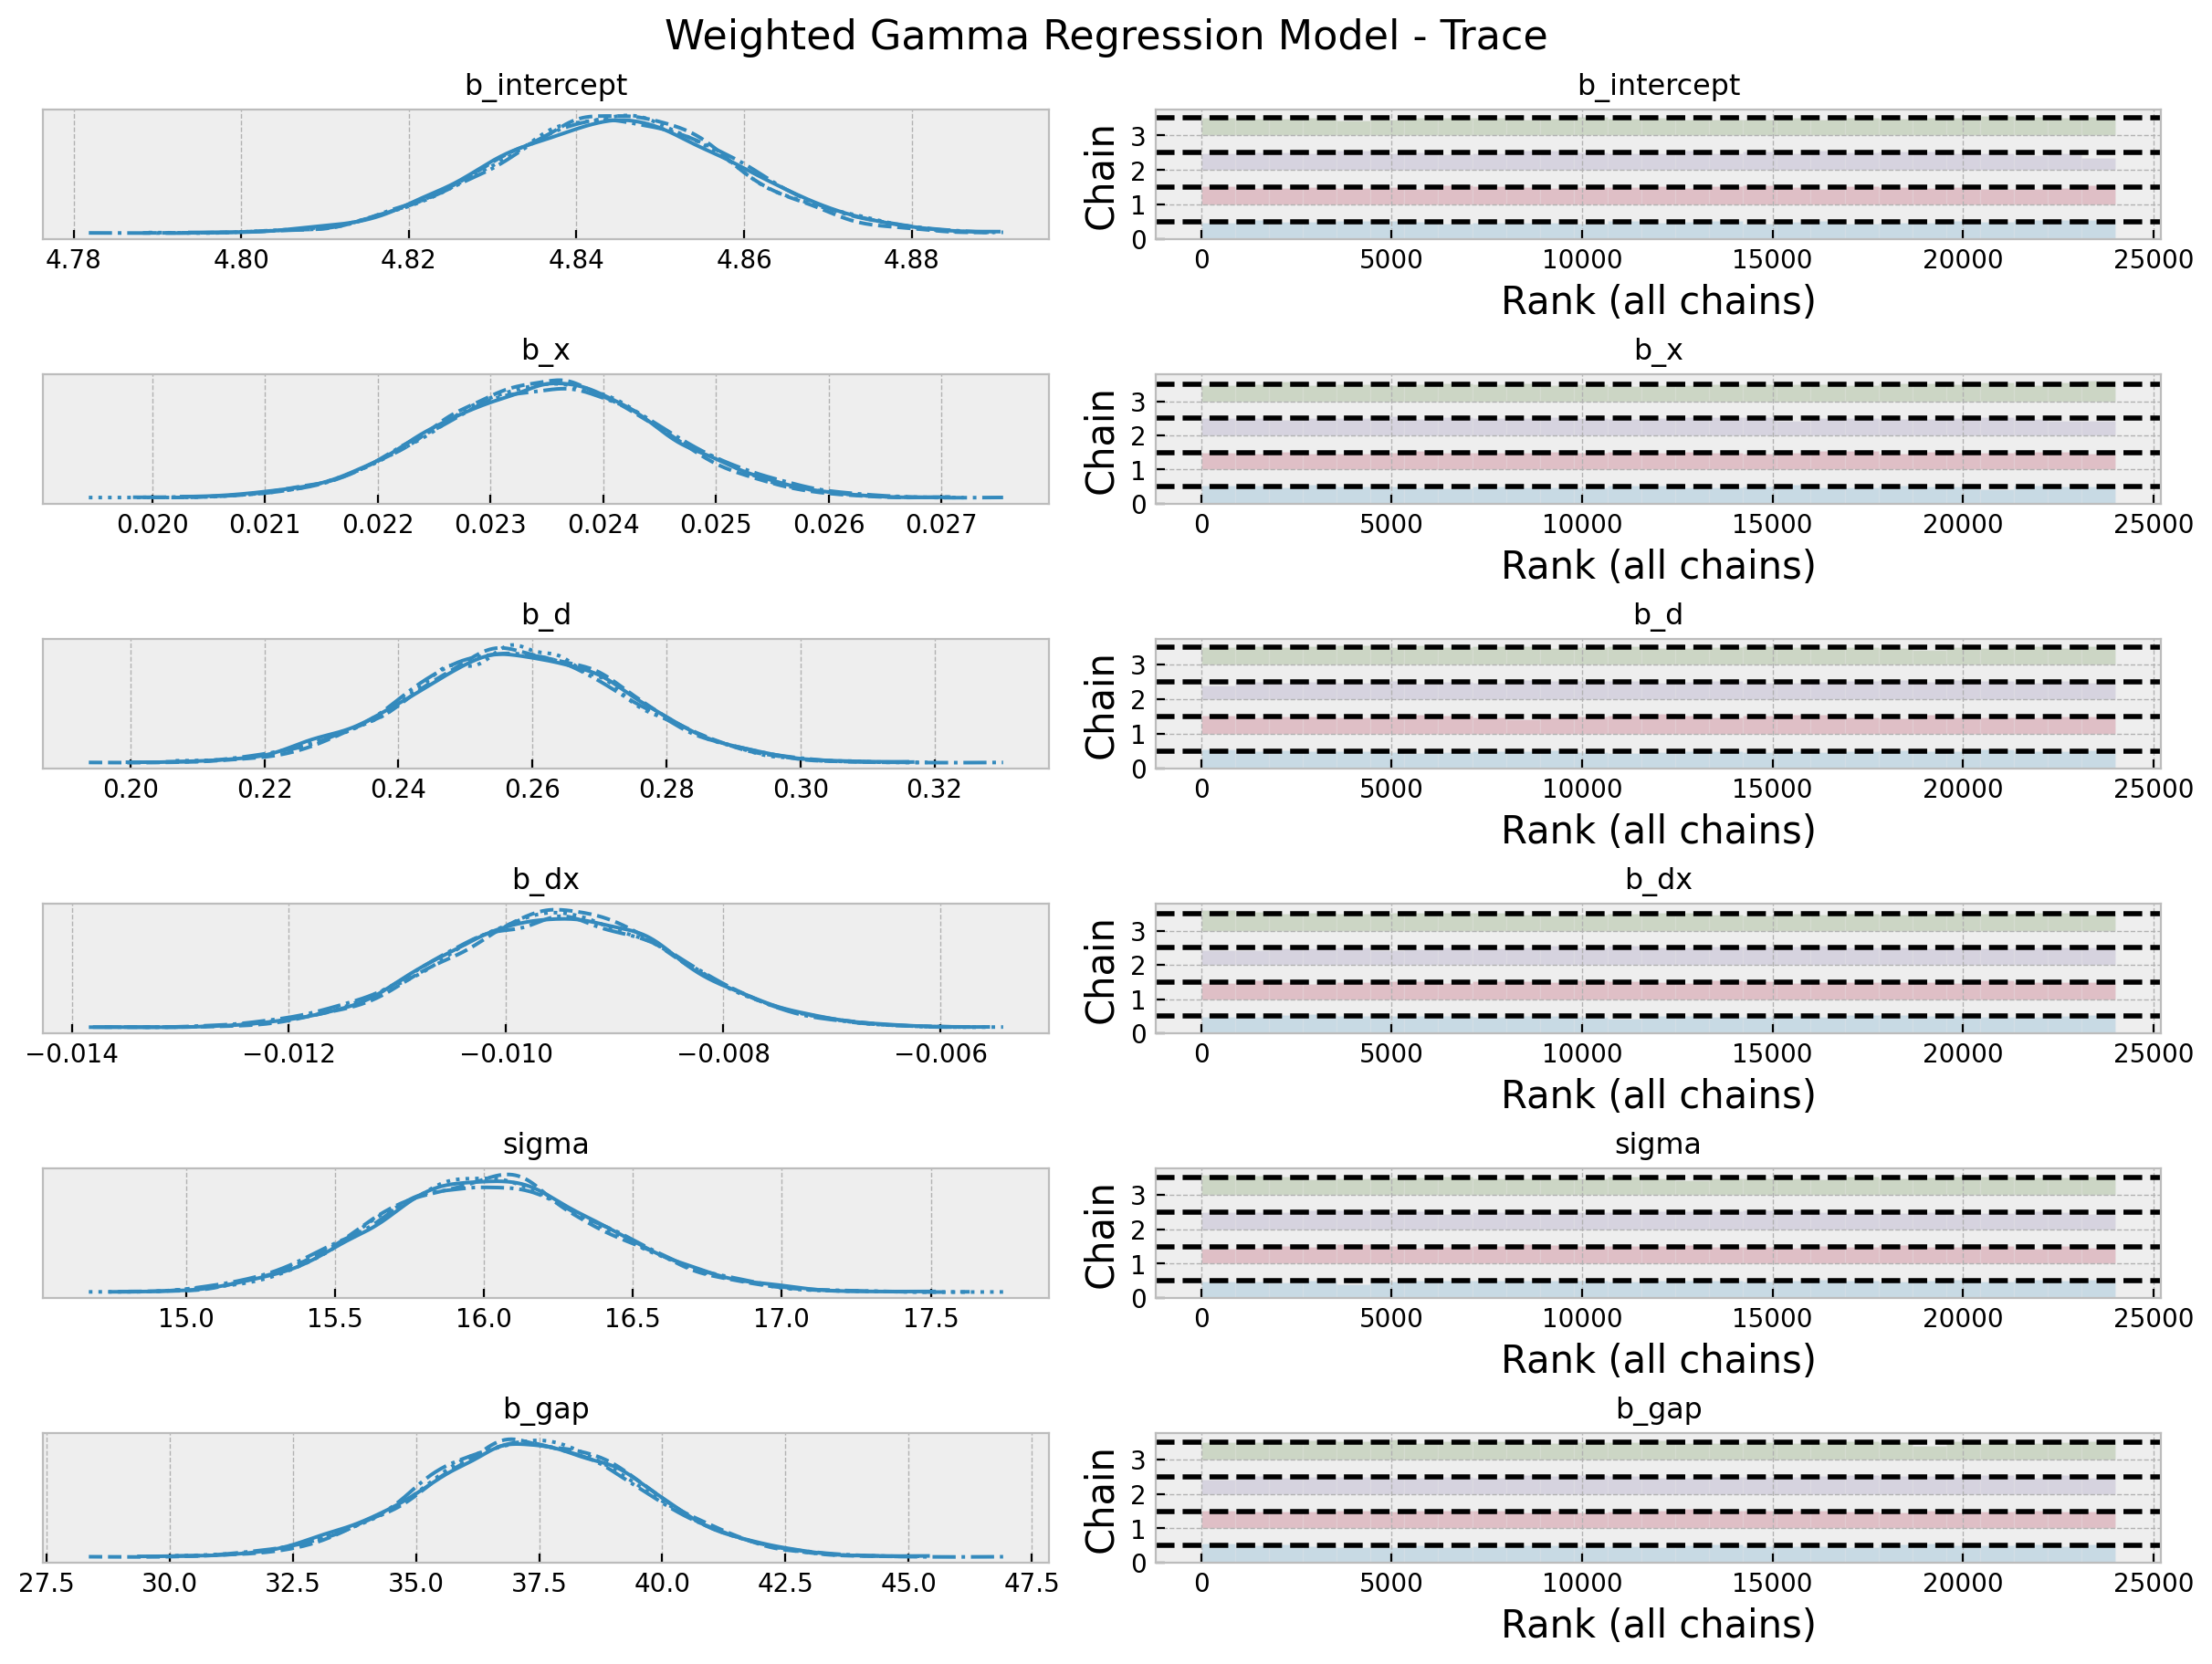

In [32]:
axes = az.plot_trace(
    data=weighted_gamma_idata,
    var_names=["b_intercept", "b_x", "b_d", "b_dx", "sigma", "b_gap"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (12, 9), "layout": "constrained"},
)
plt.gcf().suptitle("Weighted Gamma Regression Model - Trace", fontsize=16)


[Text(0.5, 1.0, 'Gamma Regression Model')]

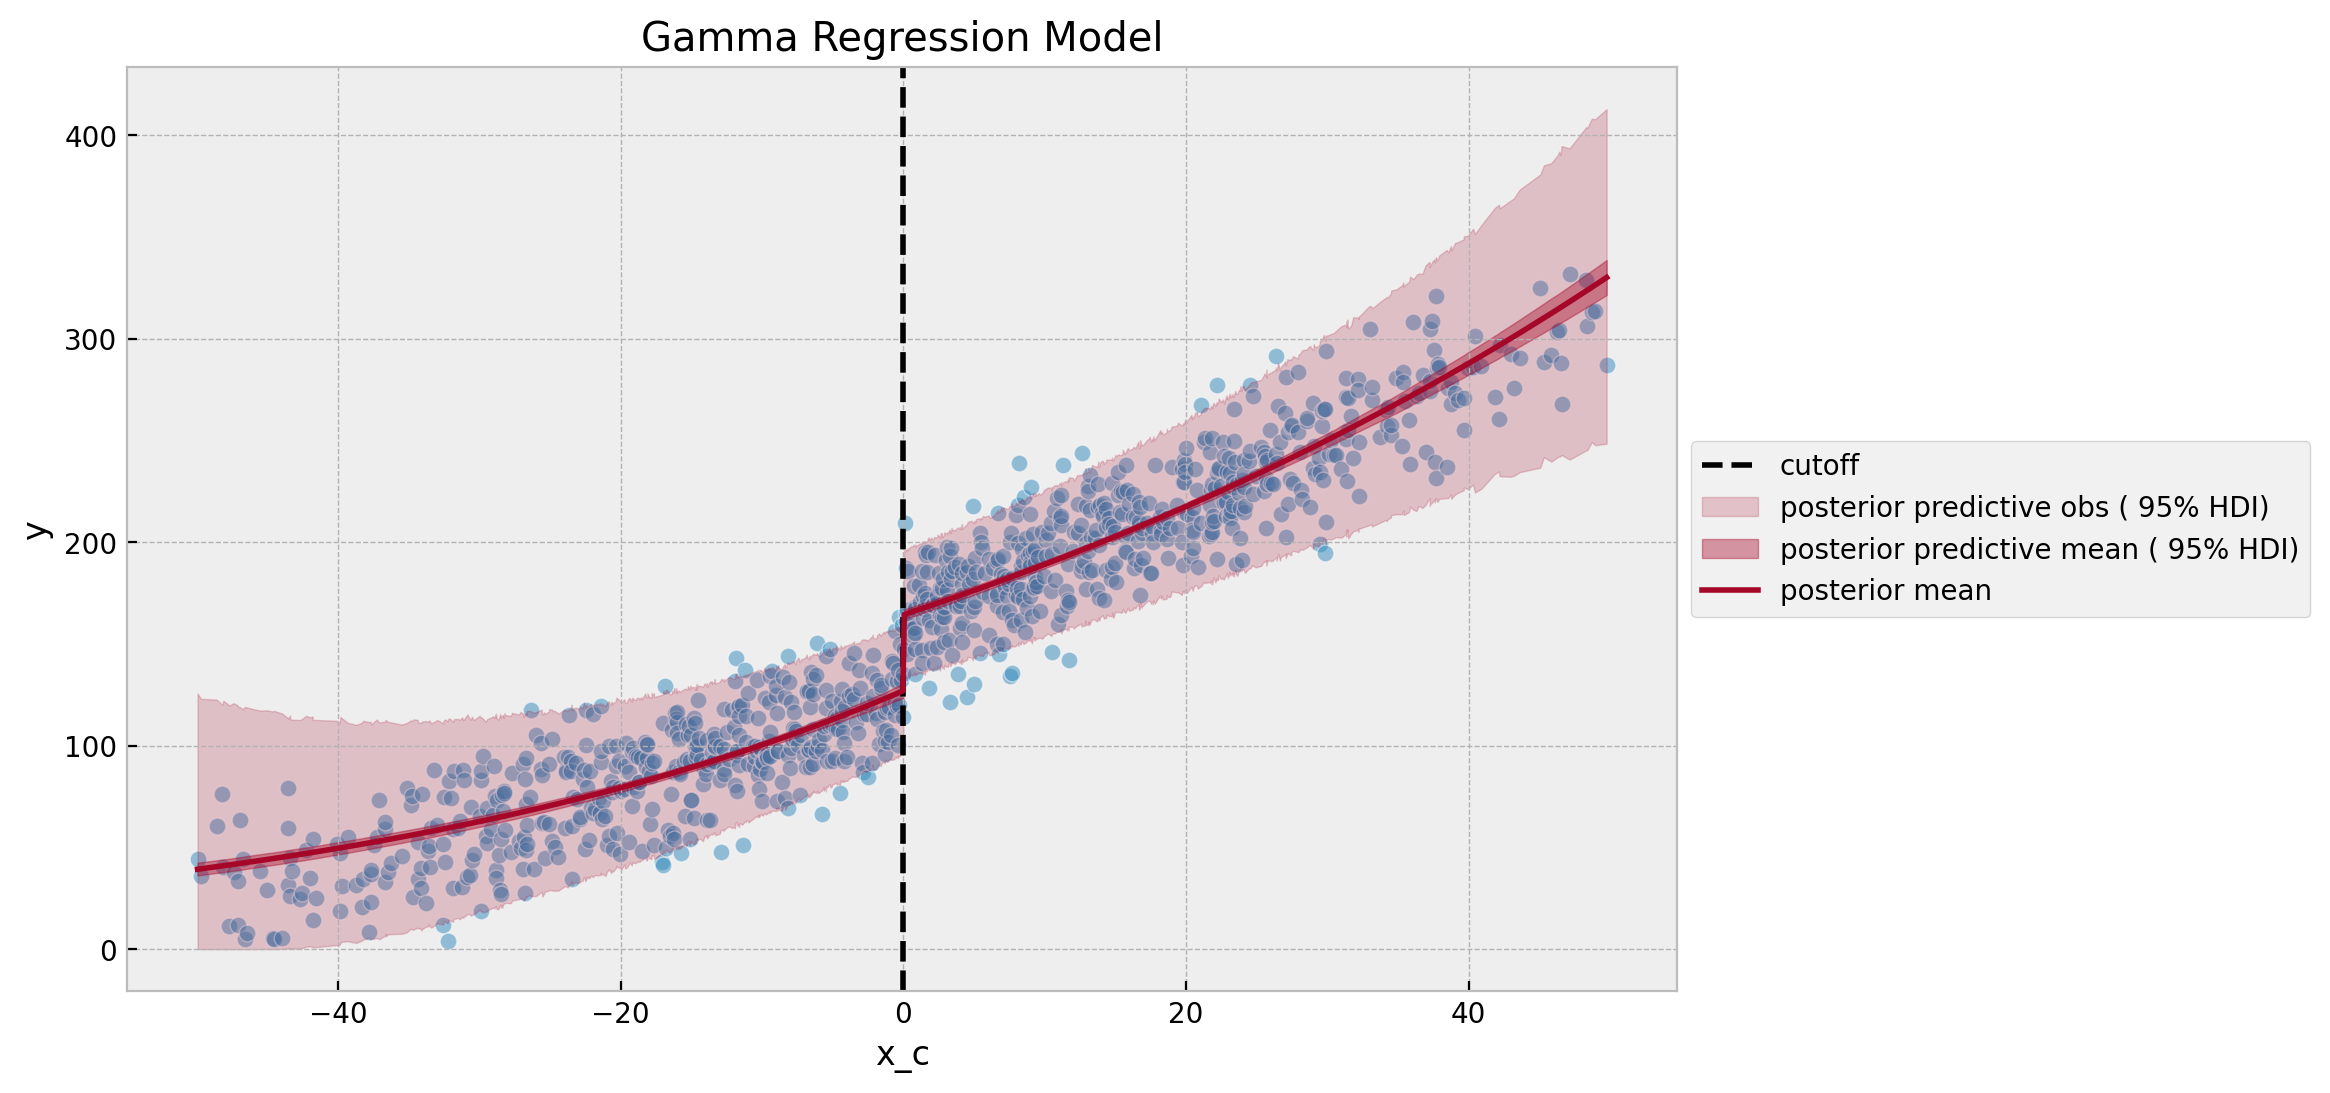

In [33]:
fig, ax = plt.subplots()
sns.scatterplot(data=data, x="x_c", y="y", color="C0", alpha=0.5, ax=ax)
ax.axvline(x=0, color="black", linestyle="--", label="cutoff")
az.plot_hdi(
    x_c,
    weighted_gamma_posterior_predictive["posterior_predictive"]["likelihood"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive obs ({1 - alpha: .0%} HDI)",
        "alpha": 0.2,
    },
    ax=ax,
)
az.plot_hdi(
    x_c,
    weighted_gamma_idata["posterior"]["mu"],
    hdi_prob=1 - alpha,
    smooth=False,
    fill_kwargs={
        "label": f"posterior predictive mean ({1 - alpha: .0%} HDI)",
        "alpha": 0.4,
    },
    ax=ax,
)
sns.lineplot(
    x=x_c,
    y=weighted_gamma_idata["posterior"]["mu"].mean(dim=("chain", "draw")),
    color="C1",
    label="posterior mean",
    ax=ax,
)
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
ax.set(title="Gamma Regression Model")


Text(0.5, 1.06, 'Estimated Discontinuity Posterior Distributions')

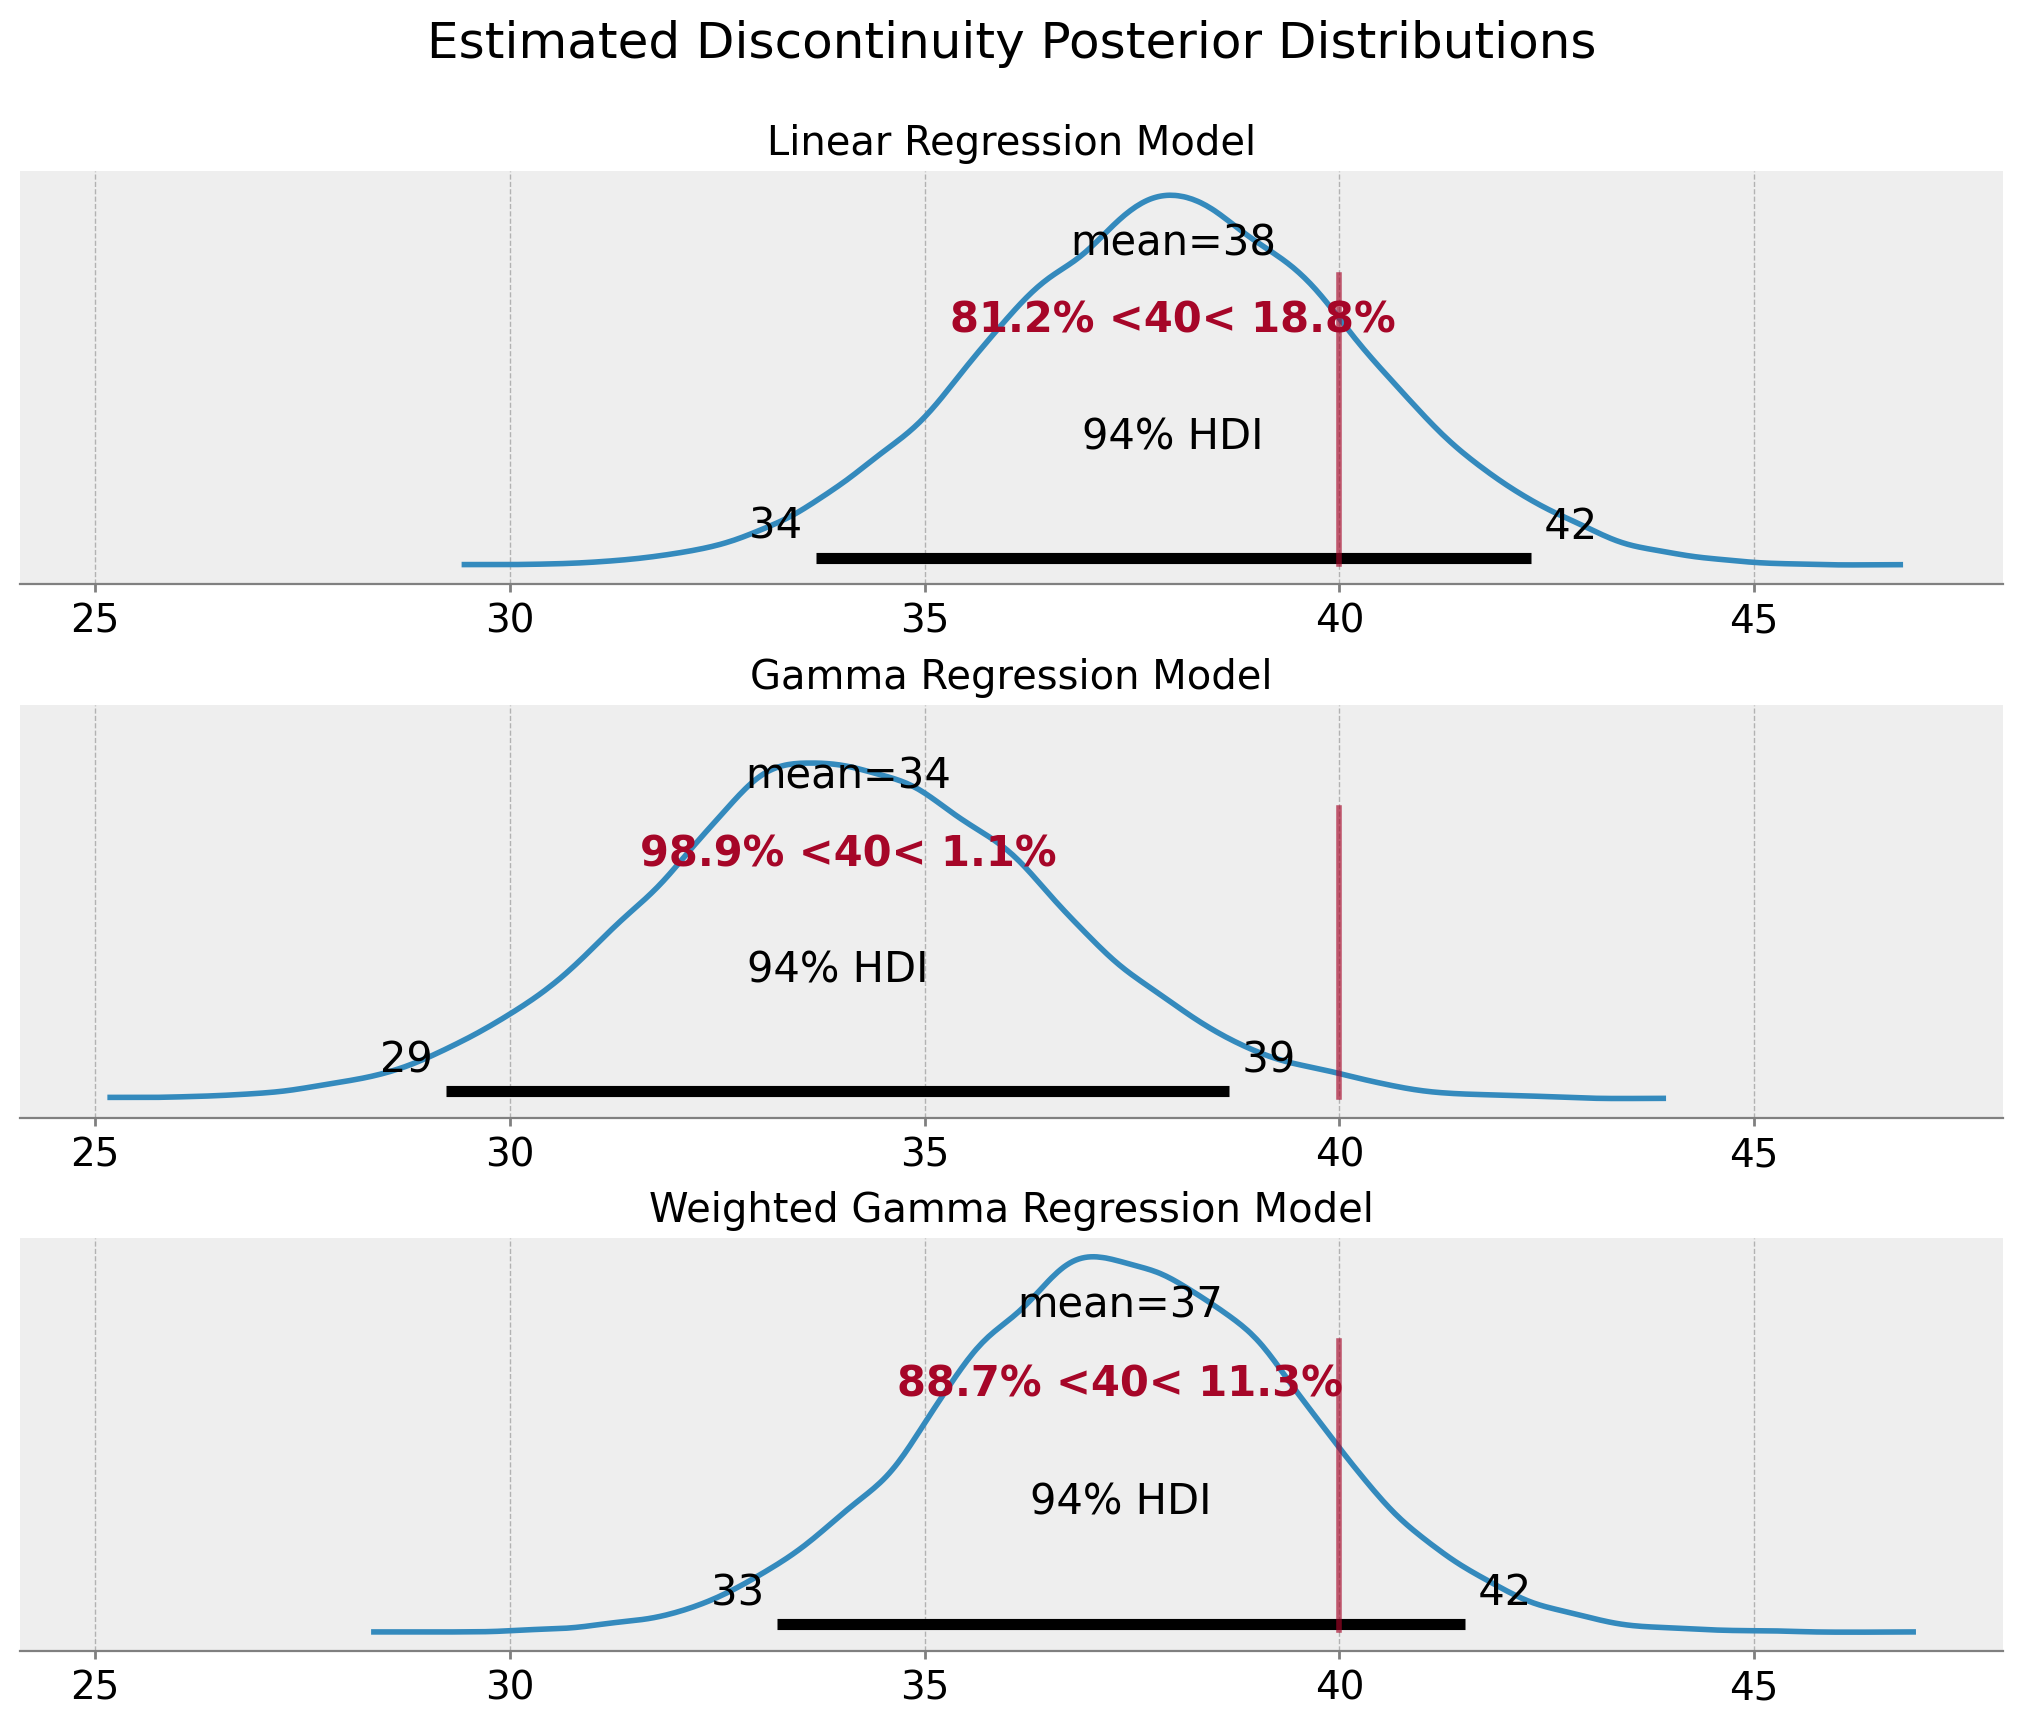

In [34]:
fig, ax = plt.subplots(
    nrows=3, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=gaussian_idata, var_names=["b_d"], ref_val=delta_true, ax=ax[0])
ax[0].set(title="Linear Regression Model")
az.plot_posterior(data=gamma_idata, var_names=["b_gap"], ref_val=delta_true, ax=ax[1])
ax[1].set(title="Gamma Regression Model")
az.plot_posterior(
    data=weighted_gamma_idata, var_names=["b_gap"], ref_val=delta_true, ax=ax[2]
)
ax[2].set(title="Weighted Gamma Regression Model")
fig.suptitle("Estimated Discontinuity Posterior Distributions", fontsize=18, y=1.06)